# Optimising Demand Response Strategies for Carbon Intelligent Load Shifting

# Processing ERA5 World Data

**NOTEBOOK PURPOSE(S):**
* Process ERA5 world data from raw grib downloads to parquet files for use in the project.

**NOTEBOOK OUTPUTS:**
* Primary output:
    * /data/era5/era5_world_reanalysis_data_2020-2025.parquet - processed ERA5 data for the years 2020-2025
* Intermediate outputs:
    * /data/era5/parquets/2020_delhi_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Delhi in 2020
    * /data/era5/parquets/2020_delhi_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Delhi in 2020
    * /data/era5/parquets/2020_mumbai_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Mumbai in 2020
    * /data/era5/parquets/2020_mumbai_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Mumbai in 2020
    * /data/era5/parquets/2021_delhi_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Delhi in 2021
    * /data/era5/parquets/2021_delhi_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Delhi in 2021
    * /data/era5/parquets/2021_mumbai_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Mumbai in 2021
    * /data/era5/parquets/2021_mumbai_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Mumbai in 2021
    * /data/era5/parquets/2022_delhi_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Delhi in 2022
    * /data/era5/parquets/2022_delhi_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Delhi in 2022
    * /data/era5/parquets/2022_mumbai_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Mumbai in 2022
    * /data/era5/parquets/2022_mumbai_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Mumbai in 2022
    * /data/era5/parquets/2023_delhi_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Delhi in 2023
    * /data/era5/parquets/2023_delhi_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Delhi in 2023
    * /data/era5/parquets/2023_mumbai_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Mumbai in 2023
    * /data/era5/parquets/2023_mumbai_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Mumbai in 2023
    * /data/era5/parquets/2024_delhi_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Delhi in 2024
    * /data/era5/parquets/2024_delhi_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Delhi in 2024
    * /data/era5/parquets/2024_mumbai_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Mumbai in 2024
    * /data/era5/parquets/2024_mumbai_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Mumbai in 2024
    * /data/era5/parquets/2025_delhi_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Delhi in 2025
    * /data/era5/parquets/2025_delhi_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Delhi in 2025
    * /data/era5/parquets/2025_mumbai_era5_reanalysis_single_levels_data_transformed.parquet - processed ERA5 data for Mumbai in 2025
    * /data/era5/parquets/2025_mumbai_era5_reanalysis_single_levels_data.parquet - raw ERA5 data for Mumbai in 2025



### Importing Libraries

In [36]:
%matplotlib inline

# ────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import polars as pl
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# Geospatial Data Handling
# ─────────────────────────────────────────────────────────────────────────────
import xarray as xr
from xarray.coding.times import CFTimedeltaCoder
import xesmf as xe

# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import display
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.features import RegularPolygonMarker

# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────
import os
import math
from datetime import datetime, timedelta
from typing import List, Optional
from functools import reduce
from zoneinfo import ZoneInfo
from pathlib import Path
import shutil
import logging
import re
import concurrent.futures
from tqdm.auto import tqdm  # Changed to auto for better notebook compatibility


## Loading Data from Local Storage

In [2]:
cwd = os.getcwd()
print("-"*120)
print("Current Working Directory and contents:\n"+"-"*120)
for root, dirs, files in os.walk(cwd):
    print(f"\nDirectory: {root}")
    print(f"Subdirectories: {dirs}\n"+ "-"*40)
    for file in sorted(files):
        print(f"-> File: {file}")


------------------------------------------------------------------------------------------------------------------------
Current Working Directory and contents:
------------------------------------------------------------------------------------------------------------------------

Directory: /Users/Daniel/Desktop/IRP_WORK_UPDATED.nosync/new_repo/MSc-Thesis-OptimisingDemandResponseStrategiesForCarbonIntelligentElectricityUse/code_and_analysis/jupyter_notebooks
Subdirectories: []
----------------------------------------
-> File: .DS_Store
-> File: marginal_emissions_data_prep.ipynb
-> File: marginal_emissions_model_development.ipynb
-> File: step1_hitachi_data_retrieval.ipynb
-> File: step2_initial_data_analysis.ipynb
-> File: step2_investigating_data_size_and_types.ipynb
-> File: step2_investigating_era5_world_data.ipynb
-> File: step3_combining_era5_datasets.ipynb
-> File: step3_combining_grid_and_weather_data.ipynb
-> File: step3_processing_era5_land_data.ipynb
-> File: step3_process

### Defining File Paths

In [38]:
# DIRECTORIES AND PATHS
root_directory = os.path.join('..', '..')
base_data_directory = os.path.join(root_directory, "data")
hitachi_data_directory = os.path.join(base_data_directory, 'hitachi')

era5_data_directory = os.path.join(base_data_directory, "era5")  # Base directory for ERA5 data

grib_era5_data_directory = os.path.join(era5_data_directory, "grib_downloads")  # Directory where the ERA5 grib files will be saved
parquets_era5_data_directory = os.path.join(era5_data_directory, "parquets")  # Directory where the ERA5 parquet files will be saved
weights_directory = os.path.join(era5_data_directory, "weights")  # Directory where the regridder weights will be saved

# Directory where the outputs are saved
outputs_directory = os.path.join(root_directory, 'outputs')
outputs_metrics_directory = os.path.join(outputs_directory, 'metrics')
outputs_images_directory = os.path.join(outputs_directory, 'images')


In [4]:
print("-"*120)
print("[grib_era5_data_directory] and contents:\n"+"-"*120)
for root, dirs, files in os.walk(grib_era5_data_directory):
    print(f"\nDirectory: {root}")
    print(f"Subdirectories: {dirs}\n"+ "-"*40)
    for file in sorted(files):
        print(f"-> File: {file}")


------------------------------------------------------------------------------------------------------------------------
[grib_era5_data_directory] and contents:
------------------------------------------------------------------------------------------------------------------------

Directory: ../../data/era5/grib_downloads
Subdirectories: []
----------------------------------------
-> File: 125ae282169904325e8bc153160be150.grib
-> File: 289f2aac241f8a158ff074a66682452e.grib
-> File: 554832a6209258041784298e5401a7ab.grib
-> File: 5aee58993569287064988fbc8ad385dd.grib
-> File: 5bcc58c42bdde8ce6b147b00099404bc.grib
-> File: ad36c26a5d6daae43c9aeab1747e078c.grib
-> File: b4eac1bff8a020500806be638e9d4ab9.grib
-> File: bc20f736fa82ab5167820d9116ab4859.grib
-> File: c8a985ffc4908e6597c4498ff596cbad.grib
-> File: d1313a3f750d6e7bd89dff34b112d8a8.grib
-> File: de87f0d77e8aeed868c68ac0daae3dc9.grib
-> File: e23fa435dfdf294eba51378e96410b31.grib


Note:

The city of Delhi is covered by
 - Latitude:  [26.000]  to  [30.000]
 - Longitude: [75.000]  to  [79.000]

The city of Mumbai is covered by
 - Latitude:  [17.000]  to  [21.000]
 - Longitude: [70.000]  to  [74.000]


In [5]:
# Copying the values from the above into corresponding file names
file_2025_delhi_raw_filename = "125ae282169904325e8bc153160be150.grib"
file_2021_mumbai_raw_filename = "289f2aac241f8a158ff074a66682452e.grib"
file_2024_delhi_raw_filename = "554832a6209258041784298e5401a7ab.grib"
file_2024_mumbai_raw_filename = "5aee58993569287064988fbc8ad385dd.grib"
file_2023_delhi_raw_filename = "5bcc58c42bdde8ce6b147b00099404bc.grib"
file_2022_mumbai_raw_filename = "ad36c26a5d6daae43c9aeab1747e078c.grib"
file_2020_delhi_raw_filename = "b4eac1bff8a020500806be638e9d4ab9.grib"
file_2020_mumbai_raw_filename = "bc20f736fa82ab5167820d9116ab4859.grib"
file_2023_mumbai_raw_filename = "c8a985ffc4908e6597c4498ff596cbad.grib"
file_2021_delhi_raw_filename = "d1313a3f750d6e7bd89dff34b112d8a8.grib"
file_2025_mumbai_raw_filename = "de87f0d77e8aeed868c68ac0daae3dc9.grib"
file_2022_delhi_raw_filename = "e23fa435dfdf294eba51378e96410b31.grib"

In [6]:
# creating a list of files
named_files = [file_2025_delhi_raw_filename, file_2024_delhi_raw_filename, file_2023_delhi_raw_filename, file_2022_delhi_raw_filename,
               file_2021_delhi_raw_filename, file_2020_delhi_raw_filename, file_2025_mumbai_raw_filename, file_2024_mumbai_raw_filename,
               file_2023_mumbai_raw_filename, file_2022_mumbai_raw_filename, file_2021_mumbai_raw_filename, file_2020_mumbai_raw_filename]

# creating a list containing full paths for each of the named files
named_filepaths = [os.path.join(grib_era5_data_directory, file) for file in named_files]

# creating a list of names that will be used as keys for a dictionary of the files
dictionary_keys = [
    "2025_delhi_era5_reanalysis_single_levels_data",
    "2024_delhi_era5_reanalysis_single_levels_data",
    "2023_delhi_era5_reanalysis_single_levels_data",
    "2022_delhi_era5_reanalysis_single_levels_data",
    "2021_delhi_era5_reanalysis_single_levels_data",
    "2020_delhi_era5_reanalysis_single_levels_data",
    "2025_mumbai_era5_reanalysis_single_levels_data",
    "2024_mumbai_era5_reanalysis_single_levels_data",
    "2023_mumbai_era5_reanalysis_single_levels_data",
    "2022_mumbai_era5_reanalysis_single_levels_data",
    "2021_mumbai_era5_reanalysis_single_levels_data",
    "2020_mumbai_era5_reanalysis_single_levels_data",
]

# creating a dictionary that maps the keys to the full file paths
named_filepaths_dictionary = dict(zip(dictionary_keys, named_filepaths))


In [7]:
print("-"*120)
print("Testing named_filepaths_dictionary:\n"+"-"*120)

print("2025 Delhi ERA5 Reanalysis Single Levels Data File Path:")
print("\texpected: [data/era5/grib_downloads/125ae282169904325e8bc153160be150.grib]")
print(f"\tactual: [{named_filepaths_dictionary['2025_delhi_era5_reanalysis_single_levels_data']}]")

print("\n" + "-"*80 + "\n")
print("2023 Mumbai ERA5 Reanalysis Single Levels Data File Path:")
print("\texpected: [data/era5/grib_downloads/c8a985ffc4908e6597c4498ff596cbad.grib]")
print(f"\tactual: [{named_filepaths_dictionary['2023_mumbai_era5_reanalysis_single_levels_data']}]")


------------------------------------------------------------------------------------------------------------------------
Testing named_filepaths_dictionary:
------------------------------------------------------------------------------------------------------------------------
2025 Delhi ERA5 Reanalysis Single Levels Data File Path:
	expected: [data/era5/grib_downloads/125ae282169904325e8bc153160be150.grib]
	actual: [../../data/era5/grib_downloads/125ae282169904325e8bc153160be150.grib]

--------------------------------------------------------------------------------

2023 Mumbai ERA5 Reanalysis Single Levels Data File Path:
	expected: [data/era5/grib_downloads/c8a985ffc4908e6597c4498ff596cbad.grib]
	actual: [../../data/era5/grib_downloads/c8a985ffc4908e6597c4498ff596cbad.grib]


## Processing

In [8]:
vars_list = ['10u','10v','2t','hcc','lcc','mcc','ssr','ssrd','tcc','tp']

In [9]:
VAR_INTERP_METHODS = {
    "tp": "conservative",
    "ssr": "conservative",
    "ssrd": "conservative",
    "2t": "bilinear",
    "10u": "bilinear",
    "10v": "bilinear",
    "tcc": "nearest_s2d",
    "hcc": "nearest_s2d",
    "mcc": "nearest_s2d",
    "lcc": "nearest_s2d",
}

#### Helper Functions

In [10]:
def cleanup_temp_dir(temp_dir: Path) -> None:
    """
    Clean up the temporary directory by removing it and logging the action.

    Parameters:
    -----------
    temp_dir : Path
        The path to the temporary directory to be deleted.

    Returns:
    --------
    None
    """
    shutil.rmtree(temp_dir)
    logging.info(f"Deleted temporary directory: {temp_dir}")

##### Geospatial

In [11]:
def regrid_to_01_variablewise(
        ds: xr.Dataset,
        var_interp_map: dict,
        fallback_method: str = "bilinear",
        weight_save_dir: str = "weights",
        region_weights_key: str = "global"
) -> xr.Dataset:
    """
    Interpolates each variable in `ds` to 0.1° resolution using per-variable methods.

    Parameters:
    -----------
    ds : xarray.Dataset
        Unified dataset with time, lat, lon.
    var_interp_map : dict
        Mapping from variable name to interpolation method.
    fallback_method : str
        Method to use for variables not in `var_interp_map`.
    weight_save_dir : str
        Directory to save regridder weights. If the directory does not exist, it will be
        created automatically.
    region_weights_key : str
        Key to use for region-specific weights.

    Returns:
    --------
    ds_out : xarray.Dataset
        Dataset with all variables interpolated to 0.1° × 0.1° resolution.
    """
    # Create 0.1° target grid
    lat_new = np.arange(ds.latitude.max(), ds.latitude.min() - 0.001, -0.1)
    lon_new = np.arange(ds.longitude.min(), ds.longitude.max() + 0.001, 0.1)
    target_grid = xr.Dataset({
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    })

    ds = ds.rename({"latitude": "lat", "longitude": "lon"})
    out_vars = {}

    # Ensure the weight save directory exists
    os.makedirs(weight_save_dir, exist_ok=True)

    for var in ds.data_vars:
        method = var_interp_map.get(var, fallback_method)

        print(f"Interpolating variable '{var}' using method: '{method}'")

        weights_path = os.path.join(weight_save_dir, f"{region_weights_key}_{var}_{method}_weights.nc")

        regridder = xe.Regridder(
            ds[[var]],
            target_grid,
            method=method,
            periodic=False,
            filename=weights_path,
            reuse_weights=os.path.exists(weights_path)
        )
        interpolated = regridder(ds[[var]])
        interpolated = interpolated.rename({"lat": "latitude", "lon": "longitude"})
        out_vars[var] = interpolated[var]

    # Merge interpolated variables
    ds_out = xr.merge([v.to_dataset() for v in out_vars.values()], join="exact")

    # Restore time
    ds_out["time"] = ds.time

    return ds_out


In [12]:
def unify_time_coordinates(
        fpath: str,
        vars_list: list,
) -> xr.Dataset:
    """
    Function to unify time coordinates across multiple ERA5 variables

    Parameters:
    ----------
    fpath : str
        Path to the GRIB file containing ERA5 data.
    vars_list : list of str
        List of variable short names to be processed.
    Returns:
    -------
    ds_unified : xarray.Dataset
        An xarray Dataset containing all variables with a unified time coordinate.
    """

    # --------------------------------------------------------------------
    # Step 1: Generate a unified time axis
    # --------------------------------------------------------------------

    # creating a dictionary to hold time coordinates for each variable
    times_dict = {}

    # Collect all time coordinates for each variable
    for var in vars_list:
        # Open the dataset for the current variable only
        with xr.open_dataset(
            fpath,
            engine="cfgrib",
            decode_timedelta=CFTimedeltaCoder(decode_via_units=True),
            backend_kwargs={"filter_by_keys": {"shortName": var}}
        ) as ds:
            # Check if the dataset has a time coordinate
            if "step" in ds.dims and "valid_time" in ds.coords:
                # For forecast data with steps, use valid_time
                tv = ds.valid_time.values.ravel()  # Flatten 2D to 1D
            else:
                # For analysis data, use time directly
                tv = ds.time.values
            times_dict[var] = pd.to_datetime(tv)

    # Get all available times from the first variable
    common_times = set(times_dict[vars_list[0]])

    # Go through all other variables and find the intersection of their times
    # update as each variable is processed
    for v in vars_list[1:]:
        common_times.intersection_update(times_dict[v])

    # Create a unified time index from the common times
    unified_times = pd.DatetimeIndex(sorted(common_times))

    # --------------------------------------------------------------------
    # Step 2: Process each variable and reindex to the unified time axis
    # --------------------------------------------------------------------

    unified_datasets = []
    for var in vars_list:
        with xr.open_dataset(
            fpath,
            engine="cfgrib",
            decode_timedelta=CFTimedeltaCoder(decode_via_units=True),
            backend_kwargs={"filter_by_keys": {"shortName": var}}
        ) as ds:

            # Handle forecast variables with step dimension
            if "step" in ds.dims and "valid_time" in ds.coords:
                # Get all dimensions except time and step
                other_dims = [d for d in ds.dims if d not in ['time', 'step']]

                # Stack time and step dimensions
                ds = ds.stack(time_step=("time", "step"))

                # Get the valid times as a 1D array
                flat_time = ds.valid_time.values.ravel()

                # Create new dataset with proper dimensions
                data = ds[var].transpose("time_step", *other_dims)
                ds_new = xr.Dataset(
                    {var: (["time"] + other_dims, data.values)},
                    coords={
                        "time": pd.to_datetime(flat_time),
                        **{dim: ds[dim] for dim in other_dims}
                    }
                )
                ds = ds_new

            # Reindex to common time axis
            ds = ds.reindex(time=unified_times, method='nearest', tolerance=pd.Timedelta("1h"))

            unified_datasets.append(ds)

    # --------------------------------------------------------------------
    # Step 3: Merge all variables into one Dataset
    # --------------------------------------------------------------------

    ds_unified = xr.merge(unified_datasets, join="exact")

    return ds_unified

In [13]:
def save_unified_to_parquet(
        ds_unified: xr.Dataset,
        key: str,
        output_dir: str = ".",
) -> str:
    """
    Flatten an xarray.Dataset (time,latitude,longitude) → Polars DataFrame
    and write it to parquet named `{key}.parquet` under `output_dir`.

    Parameters
    ----------
    ds_unified : xarray.Dataset
        The unified xarray Dataset with a common time coordinate.
    key : str
        The key to use for naming the output parquet file.
    output_dir : str, optional
        The directory where the parquet file will be saved. Defaults to the current directory.

    Returns
    -------
    None
        The funtion saves the DataFrame to a parquet file, prints confiration message, but returns None.
    """
    # 1) to pandas DataFrame & reset the MultiIndex into cols
    df = ds_unified.to_dataframe().reset_index()

    # 2) convert to Polars
    pl_df = pl.from_pandas(df)

    # 3) build output path
    out_path = os.path.join(output_dir, f"{key}.parquet")
    os.makedirs(output_dir, exist_ok=True)

    # 4) write parquet
    pl_df.write_parquet(out_path)
    print(f"Saved dataset with key {key} to: {out_path}")
    return None


##### Data Quality

In [14]:
def analyze_null_patterns(
        df: pl.DataFrame,
        colname: str,
        grouping_cols: list[str] = ["weather_longitude", "weather_latitude"]
) -> pl.DataFrame:
    """
    Analyze null patterns in a specified column of a DataFrame.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to analyze.
    colname : str
        The name of the column to analyze for null patterns.
    grouping_cols : list, optional
        List of columns to group by (default is ["weather_longitude", "weather_latitude"]).

    Returns:
    -------
    pl.DataFrame
        A DataFrame containing the following columns:
        - grouping_cols: The columns used for grouping.
        - f"{colname}_total_nulls": Total number of nulls in the specified column.
        - f"{colname}_isolated_nulls": Number of isolated nulls in the specified column.
        - f"{colname}_gaps": List of structs containing start and end timestamps of gaps longer than 1 hour.
    """
    # 0) sort by station + timestamp
    df = df.sort(grouping_cols + ["timestamp"])

    # 1) ensure every station shows up
    all_locs = df.select(grouping_cols).unique()

    # 2) basic null counts & isolated‐nulls

    # flagging the entries that are null, and those that are isolated
    flagged = (
        df
        .with_columns([
            pl.col(colname).is_null().alias("is_null"),
            # windowed shifts so we only compare within each station
            pl.col(colname).shift(1).over(grouping_cols).is_null().alias("previous_is_null"),
            pl.col(colname).shift(-1).over(grouping_cols).is_null().alias("next_is_null"),
        ])
        .with_columns([(
                        pl.col("is_null") &
                        ~pl.col("previous_is_null") &
                        ~pl.col("next_is_null")
                    ).alias("is_isolated_null")])
    )
    basic_stats = (
        flagged
        .group_by(grouping_cols)
        .agg([
            pl.col("is_null")
                .sum()
                .cast(pl.UInt32)
                .alias(f"{colname}_total_nulls"),
            pl.col("is_isolated_null")
                .sum()
                .cast(pl.UInt32)
                .alias(f"{colname}_isolated_nulls"),
        ])
    )

    # 3) flag nulls, then number each run of (null vs non‐null) per station
    runs = (
        flagged
        # first add the boolean flag
        .with_columns(
            pl.col(colname).is_null().alias("is_null")
        )
        # then number runs whenever is_null flips
        .with_columns(
            (
              pl.col("is_null") != pl.col("is_null").shift(1)
            )
            .cum_sum()
            .over(grouping_cols)
            .alias("run_id")
        )
    )

    # 4) extract only the null‐runs, get their start/end timestamps
    #    then drop any shorter than 1h, and finally implode to a list of Structs
    gap_intervals = (
        runs
        .filter(pl.col("is_null"))
        .group_by(grouping_cols + ["run_id"])
        .agg([
            pl.col("timestamp").first().alias("gap_start"),
            pl.col("timestamp").last().alias("gap_end"),
        ])
        .filter(
            (pl.col("gap_end") - pl.col("gap_start")) > pl.duration(hours=1)
        )
        .group_by(grouping_cols)
        .agg(
            pl.struct(["gap_start", "gap_end"])
              .implode()
              .alias(f"{colname}_gaps")
        )
    )

    # 5) stitch it all together, filling missing gaps‐lists with empty lists
    return (
        all_locs
        .join(basic_stats,   on=grouping_cols, how="left")
        .join(gap_intervals, on=grouping_cols, how="left")
        .with_columns(
            pl.col(f"{colname}_gaps").fill_null([])
        )
    )

In [15]:
def analyze_null_patterns_lazy(
        df: pl.LazyFrame,
        colname: str,
        grouping_cols: List[str]
) -> pl.LazyFrame:
    """
    Analyze null patterns in a specified column of a LazyFrame.
    This function identifies isolated nulls, counts total nulls, and detects gaps longer than 1 hour.

    Parameters:
    ----------
    df : pl.LazyFrame
        The LazyFrame to analyze.
    colname : str
        The name of the column to analyze for null patterns.
    grouping_cols : List[str]
        List of columns to group by (default is ["weather_longitude", "weather_latitude"])

    Returns:
    -------
    pl.LazyFrame
        A LazyFrame containing the following columns:
        - grouping_cols: The columns used for grouping.
        - f"{colname}_total_nulls": Total number of nulls in the specified column.
        - f"{colname}_isolated_nulls": Number of isolated nulls in the specified column.
        - f"{colname}_gaps": List of structs containing start and end timestamps of gaps longer than 1 hour.
    """
    prefix = f"{colname}_analysis_"
    renamed_cols = [f"{prefix}{c}" for c in grouping_cols]

    # Rename grouping columns to avoid join collisions
    df_renamed = df.with_columns([
        pl.col(c).alias(rc) for c, rc in zip(grouping_cols, renamed_cols)
    ])

    # Isolate null flag outside groupby
    flagged = df_renamed.sort(renamed_cols + ["timestamp"]).with_columns([
        pl.col(colname).is_null().alias("is_null"),
        pl.col(colname).shift(1).over(renamed_cols).is_null().alias("prev_null"),
        pl.col(colname).shift(-1).over(renamed_cols).is_null().alias("next_null"),
    ]).with_columns([
        (pl.col("is_null") & ~pl.col("prev_null") & ~pl.col("next_null")).alias("is_isolated_null")
    ])

    # Aggregate isolated + total nulls
    basic_stats = flagged.group_by(renamed_cols).agg([
        pl.col("is_null").sum().cast(pl.UInt32).alias(f"{colname}_total_nulls"),
        pl.col("is_isolated_null").sum().cast(pl.UInt32).alias(f"{colname}_isolated_nulls")
    ])

    # Gap detection
    gaps = (
        df_renamed.filter(pl.col(colname).is_null())
        .with_columns([
            (pl.col("timestamp") != pl.col("timestamp").shift(1).over(renamed_cols) + pl.duration(hours=1))
            .cast(pl.UInt8)
            .cum_sum()
            .over(renamed_cols)
            .alias("gap_id")
        ])
        .group_by(renamed_cols + ["gap_id"])
        .agg([
            pl.col("timestamp").first().alias("gap_start"),
            pl.col("timestamp").last().alias("gap_end")
        ])
        .filter((pl.col("gap_end") - pl.col("gap_start")) > pl.duration(hours=1))
        .group_by(renamed_cols)
        .agg([
            pl.struct(["gap_start", "gap_end"]).implode().alias(f"{colname}_gaps")
        ])
    )

    # Final merge
    result = (
        df_renamed.select(renamed_cols).unique()
        .join(basic_stats, on=renamed_cols, how="left")
        .join(gaps, on=renamed_cols, how="left")
        .with_columns(pl.col(f"{colname}_gaps").fill_null([]))
    )

    return result

In [16]:
def dataframe_summary(
        df: pl.DataFrame,
        name: str = None,
        filepath: str=None
) -> None:
    """
    Prints a three-part summary of a provided polars dataframe including
    Schema, Per-column memory usage, and the first 5 rows of data

    Parameters
    ----------
    df : pl.DataFrame
        The DataFrame to summarise
    name : str, optional
        An optional name for the DataFrame, which will be included in the title of the summary
    filepath : str, optional
        An optional file path to the DataFrame, which will used to display the size of the file on disk.
        If provided, the file size will be included in the summary.

    Returns
    -------
    None
        Prints the summary directly to the console.
    """
    if not isinstance(df, pl.DataFrame):
        raise TypeError("Input must be a Polars DataFrame")

    if df.is_empty():
        print("DataFrame is empty.")
        return

    title = f"DataFrame Summary{' — ' + name if name else ''} "
    print("\n" + "-" * 120)
    print(title + "\n" + "-"* 120)

    if filepath:
        file_size_disk_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"\nFile size on disk: {file_size_disk_mb:,.2f} MB")

    file_size_mem_mb = df.estimated_size() / (1024 * 1024)
    print(f"\nEstimated size in memory: {file_size_mem_mb:,.2f} MB")

    print("\nPer-column memory usage:\n"+ "-" * 120)
    mem_df = memory_usage_per_column(df)
    # pretty-print the little table
    for row in mem_df.iter_rows(named=True):
        print(f"  • {row['column']:<15s} {row['mb']:6.2f} MB  ({row['percent_of_total']:5.1f}%)")

    print("\nSchema:\n" + "-" * 120)
    for col, dtype in df.schema.items():
        print(f"  • {col}: {dtype}")

    print("\nFirst 5 rows: \n" + "-" * 120)
    display(df.head(5))

In [17]:
def memory_usage_per_column(df: pl.DataFrame) -> pl.DataFrame:
    """
    Computes the memory usage per column in a Polars DataFrame.

    Parameters
    ----------
    df : pl.DataFrame
        The Polars DataFrame for which to compute memory usage.
    Returns
    -------
    pl.DataFrame
        A DataFrame with memory usage per column:
        - column:           column name
        - bytes:            memory usage in bytes
        - mb:               memory usage in megabytes
        - percent_of_total: percentage of total memory usage
    """
    if not isinstance(df, pl.DataFrame):
        raise TypeError("Input must be a Polars DataFrame")
    if df.is_empty():
        return pl.DataFrame(columns=["column", "bytes", "mb", "percent_of_total"])
    else:
        total_bytes = df.estimated_size()
        rows = []
        for col in df.columns:
            col_bytes = df[col].estimated_size()
            mb = col_bytes / (1024**2)
            pct = (col_bytes / total_bytes * 100) if total_bytes else 0.0
            rows.append((col, col_bytes, mb, pct))
        return pl.DataFrame(rows, schema=[
            "column", "bytes", "mb", "percent_of_total"
        ],
        orient="row").sort("bytes", descending=True)

In [18]:
def parallelisation_wrapper_null_analysis(
        filepath: str,
        columns: List[str],
        grouping_cols: List[str],
        output_dir: Path,
        worker_threads: int=1
) -> List[Path]:
    """
    Process multiple columns in parallel using Polars LazyFrames.
    This function reads a Parquet file, processes each specified column
    to analyze null patterns, and writes the results to separate Parquet files.

    Parameters:
    ----------
    filepath : str
        Path to the input Parquet file containing the data.
    columns : List[str]
        List of column names to process for null pattern analysis.
    grouping_cols : List[str]
        List of columns to group by during analysis (e.g., location coordinates).
    output_dir : Path
        Directory where the output Parquet files will be saved.
    worker_threads : int, optional
        Number of worker threads to use for parallel processing. Default is 1.

    Returns:
    -------
    List[Path]
        List of paths to the output Parquet files for each processed column.
    """
    # Ensure output directory is a Path object
    output_dir = Path(output_dir)

    # Create output directory if it doesn't exist
    if not output_dir.exists():
        logging.info(f"Creating output directory: {output_dir}")
    else:
        logging.info(f"Output directory already exists: {output_dir}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Read the Parquet file as a LazyFrame - including caching for performance
    df = pl.scan_parquet(filepath).cache()

    # looping the columns to process
    logging.info(f"Starting processing of {len(columns)} columns...")
    with concurrent.futures.ThreadPoolExecutor(max_workers=worker_threads) as executor:
        # Submit tasks for each column to process and write results
        futures = {
            executor.submit(run_and_save_null_analysis, col, df.clone(), output_dir, grouping_cols): col
            for col in columns
        }
        results = []

        # Collect results as they complete
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Progress:"):
            result = future.result()
            if result:
                results.append(result)

    logging.info("All columns processed.")

    return results

In [19]:
def read_and_join_null_analyses(
        files: List[Path],
        grouping_cols: List[str]
) -> Optional[pl.LazyFrame]:
    """
    Read multiple Parquet files as LazyFrames, rename columns, and join them
    on specified grouping columns. This function handles potential schema mismatches
    and missing columns gracefully, logging errors as they occur.

    Parameters
    ----------
    files : List[Path]
        List of Path objects pointing to the Parquet files to read.
    grouping_cols : List[str]
        List of columns to group by for the join operation.

    Returns
    -------
    Optional[pl.LazyFrame]
        A LazyFrame resulting from the join of all input files on the specified grouping columns.
        Returns None if no valid frames are found or if an error occurs during processing.
    """
    lazy_frames = []

    for file in tqdm(files, desc="Loading result files"):
        colname = file.stem.replace("_nulls", "")
        prefix = f"{colname}_analysis_"
        try:
            schema = pl.read_parquet(file).schema
        except Exception as e:
            logging.error(f"Failed to read schema from {file.name}: {e}")
            continue

        rename_map = {f"{prefix}{c}": c for c in grouping_cols if f"{prefix}{c}" in schema}

        lf = pl.scan_parquet(file)

        if rename_map:
            lf = lf.rename(rename_map)

        gap_col = f"{colname}_gaps"
        if gap_col in schema:
            lf = lf.with_columns([
                pl.col(gap_col).fill_null([]).list.sort().alias(gap_col)
            ])

        # Only include if all grouping cols are now present
        try:
            if all(c in lf.collect_schema().keys() for c in grouping_cols):
                lazy_frames.append(lf)
            else:
                logging.warning(f"Skipping {file.name} due to missing grouping cols.")
        except Exception as e:
            logging.error(f"Failed to validate schema for {file.name}: {e}")

    if not lazy_frames:
        logging.error("No valid frames to join. Returning None.")
        return None

    joined = lazy_frames[0]
    for i, lf in enumerate(lazy_frames[1:], start=1):
        joined = joined.join(lf, on=grouping_cols, how="full", suffix=f"_{i}")

    return joined

In [20]:
def run_and_save_null_analysis(
        colname: str,
        df: pl.LazyFrame,
        output_dir: Path,
        grouping_cols: List[str]
) -> Optional[Path]:
    """
    Process a specific column in a LazyFrame to analyze null patterns and write results to a Parquet file.

    Parameters:
    ----------
    colname : str
        The name of the column to analyze for null patterns.
    df : pl.LazyFrame
        The LazyFrame containing the data.
    output_dir : Path
        The directory where the output Parquet file will be saved.
    grouping_cols : List[str]
        List of columns to group by for the analysis.

    Returns:
    -------
    Optional[Path]
        The path to the output Parquet file if successful, or None if an error occurs.
    """
    try:
        logging.info(f"\nProcessing: {colname}")
        # Analyze null patterns in the specified column
        metrics = analyze_null_patterns_lazy(df, colname, grouping_cols)
        # Define the output file path
        outfile = output_dir / f"{colname}_nulls.parquet"
        # Write the results to a Parquet file
        metrics.sink_parquet(outfile, engine="streaming")
        return outfile
    except Exception as e:
        logging.error(f"Failed on {colname}: {e}")
        return None

##### Visualisation

In [21]:
def plot_hourly_averages(
        df: pl.DataFrame,
        start_date: str,
        end_date: str,
        latitude_col: str = "latitude",
        longitude_col: str = "longitude",
        latitude_val: float=30.0,
        longitude_val: float=75.0,
        variables: Optional[List[str]] = None,
        figsize: tuple = (12, 6)
) -> None:
    """
    Plots hourly averages of specified variables for a given location and time period.
    Null values are replaced with 0 for plotting.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame containing weather data with columns: latitude, longitude, timestamp, and variables.
    start_date : str
        Start date in the format "YYYY-MM-DD".
    end_date : str
        End date in the format "YYYY-MM-DD".
    latitude_col : str, optional
        Name of the column containing latitude values (default is "latitude").
    longitude_col : str, optional
        Name of the column containing longitude values (default is "longitude").
    latitude_val : float, optional
        Latitude value to filter the DataFrame (default is 30.0).
    longitude_val : float, optional
        Longitude value to filter the DataFrame (default is 75.0).
    variables : List[str], optional
        List of variable names to plot. If None, all numeric columns except "hour" will be used.
    figsize : tuple, optional
        Size of the figure for plotting (default is (12, 6)).

    Returns:
    -------
    None
        Returns nothing, but displays plots for each variable.
    """
    # Convert dates to datetime objects
    tz = ZoneInfo("UTC")
    start_date = datetime.strptime(start_date, "%Y-%m-%d").replace(tzinfo=tz)
    end_date = datetime.strptime(end_date, "%Y-%m-%d").replace(tzinfo=tz) + timedelta(days=1)


    # Filter data
    filtered = df.filter(
        (pl.col(latitude_col) == latitude_val) &
        (pl.col(longitude_col) == longitude_val) &
        (pl.col("timestamp") >= start_date) &
        (pl.col("timestamp") < end_date)
    )

    if filtered.is_empty():
        raise ValueError(f"No data found for location [{latitude_val}][{longitude_val}] between {start_date} and {end_date}")

    # Extract hour
    filtered = filtered.with_columns(
        pl.col("timestamp").dt.hour().alias("hour")
    )

    # Identify numeric variables
    if variables is None:
        numeric_cols = [col for col, dtype in filtered.schema.items()
                       if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]
        variables = [col for col in numeric_cols if col != "hour"]

    # Calculate hourly averages, filling nulls with 0
    hourly_avg = (
        filtered.group_by("hour")
        .agg(
            *[pl.col(var).cast(pl.Float64).fill_null(0).mean().alias(f"avg_{var}") for var in variables]
        )
        .sort("hour")
    )

    # Plot each variable
    for var in variables:
        plt.figure(figsize=figsize)

        hours = [int(h) for h in hourly_avg["hour"].to_list()]
        values = hourly_avg[f"avg_{var}"].to_list()

        if all(v == 0 or v is None for v in values):
            print(f"[SKIP] {var}: All values are 0 or None")
            continue

        plt.plot(hours, values, marker='o', label=f"Hourly {var}")

        ax = plt.gca()
        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 2))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        plt.xticks(rotation=45)

        plt.title(f"Hourly {var} (Nulls=0)\n{start_date} to {end_date}")
        plt.xlabel("Hour of Day")
        plt.ylabel(var)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [22]:
def plot_hourly_boxplots_by_month_or_quarter(
        df: pl.DataFrame,
        variable: str = "temperature",
        latitude_col: str = "latitude",
        longitude_col: str = "longitude",
        latitude_val: float = 30.0,
        longitude_val: float = 75.0,
        use_quarters: bool = False
):
    """
    Plots hourly boxplots of a specified variable for a given location,
    grouped by month or quarter.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame containing the data.
    variable : str, optional
        The variable to plot (default is "temperature").
    latitude_col : str, optional
        The name of the column containing latitude values (default is "latitude").
    longitude_col : str, optional
        The name of the column containing longitude values (default is "longitude").
    latitude_val : float, optional
        The latitude value to filter the data (default is 30.0).
    longitude_val : float, optional
        The longitude value to filter the data (default is 75.0).
    use_quarters : bool, optional
        If True, group by quarter; if False, group by month (default is False).

    Returns:
    -------
    None
        Displays the boxplots for the specified variable.
    """
    # Filter to the selected location and extract time parts
    df = (
        df.filter(
            (pl.col(latitude_col) == latitude_val) &
            (pl.col(longitude_col) == longitude_val))
        .with_columns([
            pl.col("timestamp").dt.hour().alias("hour"),
            pl.col("timestamp").dt.month().alias("month"),
            ((pl.col("timestamp").dt.month() - 1) // 3 + 1).alias("quarter"),
        ])
    )

    # Use quarters or months for grouping
    group_col = "quarter" if use_quarters else "month"
    group_labels = [f"Q{i}" for i in range(1, 5)] if use_quarters else [
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ]
    n_rows = 4 if use_quarters else 12

    # Cast Decimal columns to float if needed
    decimal_cols = [col for col, dtype in df.schema.items() if "Decimal" in str(dtype)]
    df = df.with_columns([pl.col(c).cast(pl.Float64) for c in decimal_cols])

    # Convert to pandas for plotting
    df_pd = df.select(["hour", group_col, variable]).to_pandas()

    # Create plot grid (1 column of n_rows)
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, n_rows * 2.5), sharey=True)

    # Ensure axes is always a list/array even when n_rows=1
    if n_rows == 1:
        axes = [axes]

    for i, grp_val in enumerate(sorted(df_pd[group_col].dropna().unique())):
        ax = axes[i]
        subset = df_pd[df_pd[group_col] == grp_val]

        box_data = []
        for h in range(24):
            values = subset[subset["hour"] == h][variable].dropna()
            box_data.append(values.tolist() if not values.empty else [])

        ax.boxplot(box_data, positions=range(24), showfliers=False)
        ax.set_xlim(-0.5, 23.5)
        ax.set_xticks(range(0, 24))
        ax.set_title(f"{group_labels[i]}")
        ax.set_xlabel("Hour of Day")
        ax.set_ylabel(variable.replace("_", " ").capitalize())
        ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

In [23]:
def valid_row(
        r: dict,
        lat_col: str = "latitude",
        lon_col: str = "longitude"
) -> bool:
    """
    Row has non-null lat/lon? Works with iter_rows(named=True) dict rows.

    Parameters
    ----------
    r : dict
        The row to check.
    lat_col : str
        The name of the latitude column.
    lon_col : str
        The name of the longitude column.

    Returns
    -------
    bool
        True if the row has non-null lat/lon, False otherwise.
    """
    return (r.get(lat_col) is not None) and (r.get(lon_col) is not None)

In [24]:
def haversine_km(
        lat1: float,
        lon1: float,
        lat2: float,
        lon2: float
) -> float:
    """
    Great-circle distance in km.

    Parameters:
    ----------
    lat1 : float
        Latitude of the first point.
    lon1 : float
        Longitude of the first point.
    lat2 : float
        Latitude of the second point.
    lon2 : float
        Longitude of the second point.

    Returns:
    -------
    float
        Great-circle distance between the two points in kilometers.
    """
    R = 6371.0088
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dl = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dl/2)**2
    return 2 * R * math.asin(math.sqrt(a))


In [25]:
def filter_by_radius(
    df: pl.DataFrame,
    center_lat: float,
    center_lon: float,
    radius_km: float,
    *,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
) -> pl.DataFrame:
    """
    Keep rows within radius_km of (center_lat, center_lon).

    Parameters:
    ----------
    df : pl.DataFrame
        DataFrame to filter.
    center_lat : float
        Latitude of the center point.
    center_lon : float
        Longitude of the center point.
    radius_km : float
        Radius in kilometers.
    lat_col : str
        Name of the latitude column.
    lon_col : str
        Name of the longitude column.

    Returns:
    -------
    pl.DataFrame
        Filtered DataFrame containing only rows within the specified radius.
    """
    if df.is_empty():
        return df
    keep = []
    for r in df.iter_rows(named=True):
        if not valid_row(r, lat_col, lon_col):
            continue
        if haversine_km(r[lat_col], r[lon_col], center_lat, center_lon) <= radius_km:
            keep.append(r)
    return pl.DataFrame(keep) if keep else df.head(0)


In [26]:
def _half_deg_for_square(
        lat: float,
        side_km: float
) -> tuple[float, float]:
    """
    Convert an N-by-N km square centered at (lat, lon) into +/- degrees.
    Good approximation for India-ish latitudes.

    Parameters:
    -----------
    lat : float
        Latitude of the center point.
    side_km : float
        Side length of the square in kilometers.

    Returns:
    --------
    tuple[float, float]
        A tuple containing the half-degree offsets for latitude and longitude.

    """
    dlat = (side_km / 2) / 110.574
    denom = max(1e-9, 111.320 * math.cos(math.radians(lat)))  # avoid div-by-zero near poles
    dlon = (side_km / 2) / denom
    return dlat, dlon


In [27]:
def add_markers(
    m: folium.Map,
    pdf: pl.DataFrame,
    *,
    color: str = "green",
    point_radius: int = 2,            # pixel-size markers
    line_weight: int = 2,             # border weight for geo-size shapes
    fill_opacity: float = 0.75,
    popup_cols: tuple[str, ...] = (),
    cluster: MarkerCluster | None = None,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    marker_shape: str = "circle",     # "circle" | "square" | "hex"
    square_rotation: int = 45,
    circle_radius_km: float | None = None,
    square_side_km: float | None = None,
) -> None:
    """
    - If circle_radius_km/square_side_km is set (and shape matches), draw geo-sized
      Circle/Rectangle that keep constant real-world size.
    - Otherwise draw pixel-sized CircleMarker/RegularPolygonMarker.
    - If a geo-sized shape is requested, clustering is ignored (vector layers).

    Parameters:
    ----------
    m : folium.Map
        The folium map to add markers to.
    pdf : pl.DataFrame
        The data containing the points to be marked.
    color : str
        The color of the markers.
    point_radius : int
        The radius of the point markers (in pixels).
    line_weight : int
        The weight of the lines (for polygon markers).
    fill_opacity : float
        The fill opacity of the markers.
    popup_cols : tuple[str, ...]
        The columns to include in the marker popups.
    cluster : MarkerCluster | None
        The marker cluster to add the markers to (if any).
    lat_col : str
        The name of the column containing the latitude values.
    lon_col : str
        The name of the column containing the longitude values.
    marker_shape : str
        The shape of the markers (e.g., "circle", "square", "hex").
    square_rotation : int
        The rotation angle of square markers (in degrees).
    circle_radius_km : float | None
        The radius of circle markers (in kilometers).
    square_side_km : float | None
        The side length of square markers (in kilometers).

    Returns:
    --------
    None
        Adds markers to the provided folium map.
    """
    # geo-sized rectangles/circles can’t live inside MarkerCluster
    prefer_geo = (
        (marker_shape == "square" and square_side_km is not None) or
        (marker_shape == "circle" and circle_radius_km is not None)
    )
    if prefer_geo and cluster is not None:
        # silently drop clustering for these layers
        target = m
    else:
        target = cluster if cluster is not None else m

    for r in pdf.iter_rows(named=True):
        lat = r.get(lat_col); lon = r.get(lon_col)
        if lat is None or lon is None:
            continue

        bits = [f"{c}: {r[c]}" for c in popup_cols if c in r and r[c] is not None]
        tooltip = "<br>".join(bits) if bits else f"({lat:.4f}, {lon:.4f})"

        # --- fixed geo size (scales with zoom correctly) ---
        if marker_shape == "square" and square_side_km is not None:
            dlat, dlon = _half_deg_for_square(lat, square_side_km)
            folium.Rectangle(
                bounds=[[lat - dlat, lon - dlon], [lat + dlat, lon + dlon]],
                color=color, weight=line_weight, fill=True,
                fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
            continue

        if marker_shape == "circle" and circle_radius_km is not None:
            folium.Circle(
                location=[lat, lon],
                radius=circle_radius_km * 1000.0,     # meters
                color=color, weight=line_weight, fill=True,
                fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
            continue

        # --- pixel-sized (your original look) ---
        if marker_shape == "square":
            RegularPolygonMarker(
                location=[lat, lon],
                number_of_sides=4,
                radius=point_radius,                   # pixels to vertex
                rotation=square_rotation,
                color=color,
                fill=True, fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
        elif marker_shape == "hex":
            RegularPolygonMarker(
                location=[lat, lon],
                number_of_sides=6,
                radius=point_radius,
                color=color,
                fill=True, fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
        else:
            folium.CircleMarker(
                location=[lat, lon],
                radius=point_radius,
                color=color, fill=True, fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)


In [28]:
def add_legend(
        m: folium.Map,
        items: list[tuple[str, str]],
        title: str = "Legend",
        position: str = "bottomleft"
) -> None:
    """
    Add a legend to the folium map.

    Parameters:
    ----------
    m : folium.Map
        The folium map to add the legend to.
    items : list[tuple[str, str]]
        A list of (label, color) tuples for the legend items.
    title : str
        The title of the legend.
    position : str
        The position of the legend on the map.

    Returns:
    -------
    None
        Adds a legend to the provided folium map.
    """
    pos_css = {
        "topleft":      "top:10px;left:10px;",
        "topright":     "top:10px;right:10px;",
        "bottomleft":   "bottom:10px;left:10px;",
        "bottomright":  "bottom:10px;right:10px;",
    }[position]

    html = f"""
    <div style="position:fixed;{pos_css}
                z-index:9999;background:white;border:1px solid #999;border-radius:6px;
                padding:8px 10px;font:13px/1.3 Arial, sans-serif;box-shadow:0 1px 4px rgba(0,0,0,.2);">
      <div style="font-weight:600;margin-bottom:6px;">{title}</div>
      {''.join(f'<div style="display:flex;align-items:center;margin:3px 0;">'
               f'<span style="display:inline-block;width:14px;height:14px;background:{col};'
               f'border:2px solid #c00;border-radius:2px;margin-right:8px;"></span>'
               f'<span>{lab}</span></div>' for lab, col in items)}
    </div>
    """
    m.get_root().html.add_child(folium.Element(html))


In [29]:
def make_map(
    with_df: pl.DataFrame,
    zero_df: pl.DataFrame | None = None,   # <-- now optional
    *,
    title: str,
    html_basename: str,
    output_dir: str,
    center: list[float] | tuple[float, float] | None = None,
    zoom_start: int = 6,
    variant: str = "both",      # "both" or "withdata"
    popup_cols: tuple[str, ...] = ("city", "temperature", "timestamp"),
    tiles: str = "OpenStreetMap",
    map_width: str | int = "100%",
    map_height: str | int = "650px",
    use_cluster: bool = True,
    color_with: str = "green",
    color_zero: str = "red",
    color_withdata_only: str = "blue",
    point_radius_with: int = 2,
    point_radius_zero: int = 2,
    fill_opacity: float = 0.75,
    line_weight: int = 2,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    marker_shape_with: str = "square",
    marker_shape_zero: str = "square",
    # geo-sized options
    circle_radius_km_with: float | None = None,
    circle_radius_km_zero: float | None = None,
    square_side_km_with: float | None = None,
    square_side_km_zero: float | None = None,
    # legend options
    show_legend: bool = True,
    legend_position: str = "bottomleft",
) -> str | None:
    """
    Create an interactive folium map with two layers:
    - One for the "with data" points
    - One for the "zero data" points

    Parameters:
    ----------
    with_df : pl.DataFrame
        DataFrame containing points with data.
    zero_df : pl.DataFrame
        DataFrame containing points with zero data.
    title : str
        The title of the map.
    html_basename : str
        The base name for the HTML file (without extension).
    output_dir : str
        The directory where the HTML file will be saved.
    center : list[float] | tuple[float, float] | None
        The initial center of the map.
    zoom_start : int
        The initial zoom level of the map.
    variant : str
        The variant of the map to create ("both" or "withdata").
    popup_cols : tuple[str, ...]
        The columns to use for the popup information.
    tiles : str
        The map tileset to use.
    map_width : str | int
        The width of the map.
    map_height : str | int
        The height of the map.
    use_cluster : bool
        Whether to use clustering for the markers.
    color_with : str
        The color for the "with data" markers.
    color_zero : str
        The color for the "zero data" markers.
    color_withdata_only : str
        The color for the "with data only" markers.
    point_radius_with : int
        The radius of the points for the "with data" markers.
    point_radius_zero : int
        The radius of the points for the "zero data" markers.
    fill_opacity : float
        The fill opacity for the markers.
    line_weight : int
        The weight of the lines for the markers.
    lat_col : str
        The name of the column containing the latitude values.
    lon_col : str
        The name of the column containing the longitude values.
    marker_shape_with : str
        The shape of the markers for the "with data" points.
    marker_shape_zero : str
        The shape of the markers for the "zero data" points.
    circle_radius_km_with : float | None
        The radius of the circles for the "with data" points.
    circle_radius_km_zero : float | None
        The radius of the circles for the "zero data" points.
    square_side_km_with : float | None
        The side length of the squares for the "with data" points.
    square_side_km_zero : float | None
        The side length of the squares for the "zero data" points.
    show_legend : bool
        Whether to show the legend on the map.
    legend_position : str
        The position of the legend on the map.

    Returns:
    --------
    str | None
        The HTML file path of the generated map or None if no valid coordinates are found.

    """
    os.makedirs(output_dir, exist_ok=True)

    # --- single-DF mode: if zero_df is None, force 'withdata' and create empty zero_df
    if zero_df is None:
        variant = "withdata"
        # empty df with just the lat/lon columns for internal flow
        try:
            zero_df = with_df.select([pl.col(lat_col), pl.col(lon_col)]).head(0)
        except Exception:
            zero_df = pl.DataFrame({lat_col: [], lon_col: []})

    # center from data if not provided
    if center is None:
        coords = []
        for df in (with_df, zero_df):
            if not df.is_empty():
                coords += [
                    (r[lat_col], r[lon_col])
                    for r in df.iter_rows(named=True)
                    if valid_row(r, lat_col, lon_col)
                ]
        if not coords:
            print(f"[skip] {title}: no valid coordinates")
            return None
        center = [sum(x for x, _ in coords)/len(coords),
                  sum(y for _, y in coords)/len(coords)]

    m = folium.Map(location=center, zoom_start=zoom_start,
                   tiles=tiles, width=map_width, height=map_height)

    # overlay groups so LayerControl gets toggles
    fg_with = folium.FeatureGroup(name="With data", show=True)
    fg_zero = folium.FeatureGroup(name="No/zero data", show=True)

    # whether each layer uses geo-sized shapes (bypass clustering)
    with_geo = (
        (marker_shape_with == "square" and square_side_km_with is not None) or
        (marker_shape_with == "circle" and circle_radius_km_with is not None)
    )
    zero_geo = (
        (marker_shape_zero == "square" and square_side_km_zero is not None) or
        (marker_shape_zero == "circle" and circle_radius_km_zero is not None)
    )

    # clusters live inside the feature groups (so toggling works)
    cluster_with = MarkerCluster() if (use_cluster and not with_geo) else None
    cluster_zero = MarkerCluster() if (use_cluster and not zero_geo) else None
    if cluster_with: cluster_with.add_to(fg_with)
    if cluster_zero: cluster_zero.add_to(fg_zero)

    if variant == "both":
        if with_df.height:
            add_markers(
                fg_with, with_df,
                color=color_with, point_radius=point_radius_with,
                line_weight=line_weight, fill_opacity=fill_opacity,
                popup_cols=popup_cols,
                cluster=cluster_with, lat_col=lat_col, lon_col=lon_col,
                marker_shape=marker_shape_with,
                circle_radius_km=circle_radius_km_with,
                square_side_km=square_side_km_with,
            )
            fg_with.add_to(m)

        if zero_df.height:
            add_markers(
                fg_zero, zero_df,
                color=color_zero, point_radius=point_radius_zero,
                line_weight=line_weight, fill_opacity=fill_opacity,
                popup_cols=("city",),
                cluster=cluster_zero, lat_col=lat_col, lon_col=lon_col,
                marker_shape=marker_shape_zero,
                circle_radius_km=circle_radius_km_zero,
                square_side_km=square_side_km_zero,
            )
            fg_zero.add_to(m)

        if show_legend:
            add_legend(m, [("With data", color_with), ("No/zero data", color_zero)],
                       title="Sites", position=legend_position)

    elif variant == "withdata":
        if with_df.height:
            add_markers(
                fg_with, with_df,
                color=color_withdata_only, point_radius=point_radius_with,
                line_weight=line_weight, fill_opacity=fill_opacity,
                popup_cols=popup_cols,
                cluster=cluster_with, lat_col=lat_col, lon_col=lon_col,
                marker_shape=marker_shape_with,
                circle_radius_km=circle_radius_km_with,
                square_side_km=square_side_km_with,
            )
            fg_with.add_to(m)

        if show_legend:
            add_legend(m, [("With data", color_withdata_only)],
                       title="Sites", position=legend_position)
    else:
        raise ValueError("variant must be 'both' or 'withdata'")

    # title banner
    m.get_root().html.add_child(folium.Element(
        f'<div style="position:fixed;top:10px;left:50%;transform:translateX(-50%);'
        f'background:white;padding:8px 15px;border:1px solid #999;border-radius:6px;'
        f'font:600 16px/1 Arial;z-index:1000;">{title}</div>'
    ))

    folium.LayerControl(collapsed=False).add_to(m)

    out_html = os.path.join(output_dir, f"{html_basename}.html")
    m.save(out_html)
    print(f"[ok] wrote {out_html}")
    return out_html

### Transformations

#### Transformations 1: Unifying Time Axis, Regridding, Saving as Parquet

In [29]:
# reminder of the output directory: parquets_era5_data_directory
for key, file_path in named_filepaths_dictionary.items():
    region = "delhi" if "delhi" in key else "mumbai"
    # 1) Load and unify time
    ds = unify_time_coordinates(file_path, vars_list)

    # 2) Regrid with per-variable interpolation
    ds_interp = regrid_to_01_variablewise(ds,
                                          VAR_INTERP_METHODS,
                                          fallback_method="bilinear",
                                          weight_save_dir=weights_directory,
                                          region_weights_key=region)

    # 3) Save to Parquet
    save_unified_to_parquet(ds_interp, key, parquets_era5_data_directory)

    # Cleanup
    ds.close()
    ds_interp.close()

Interpolating variable 'u10' using method: 'bilinear'
Interpolating variable 'v10' using method: 'bilinear'
Interpolating variable 't2m' using method: 'bilinear'
Interpolating variable 'hcc' using method: 'nearest_s2d'
Interpolating variable 'lcc' using method: 'nearest_s2d'
Interpolating variable 'mcc' using method: 'nearest_s2d'
Interpolating variable 'ssr' using method: 'conservative'
Interpolating variable 'ssrd' using method: 'conservative'
Interpolating variable 'tcc' using method: 'nearest_s2d'
Interpolating variable 'tp' using method: 'conservative'
Saved dataset with key 2025_delhi_era5_reanalysis_single_levels_data to: ../../data/era5/parquets/2025_delhi_era5_reanalysis_single_levels_data.parquet
Interpolating variable 'u10' using method: 'bilinear'
Interpolating variable 'v10' using method: 'bilinear'
Interpolating variable 't2m' using method: 'bilinear'
Interpolating variable 'hcc' using method: 'nearest_s2d'
Interpolating variable 'lcc' using method: 'nearest_s2d'
Interpol

In [30]:
# Viewing the directory contents after saving
print("\n" + "-"*120)
print("[era5_data_directory] and contents after saving parquet files:\n" + "-"*120)
for root, dirs, files in os.walk(era5_data_directory):
    print(f"\nDirectory: {root}")
    print(f"Subdirectories: {dirs}\n"+ "-"*40)
    for file in sorted(files):
        print(f"-> File: {file}")


------------------------------------------------------------------------------------------------------------------------
[era5_data_directory] and contents after saving parquet files:
------------------------------------------------------------------------------------------------------------------------

Directory: ../../data/era5
Subdirectories: ['weights', 'grib_downloads', 'parquets']
----------------------------------------
-> File: .DS_Store

Directory: ../../data/era5/weights
Subdirectories: []
----------------------------------------
-> File: delhi_hcc_nearest_s2d_weights.nc
-> File: delhi_lcc_nearest_s2d_weights.nc
-> File: delhi_mcc_nearest_s2d_weights.nc
-> File: delhi_ssr_conservative_weights.nc
-> File: delhi_ssrd_conservative_weights.nc
-> File: delhi_t2m_bilinear_weights.nc
-> File: delhi_tcc_nearest_s2d_weights.nc
-> File: delhi_tp_conservative_weights.nc
-> File: delhi_u10_bilinear_weights.nc
-> File: delhi_v10_bilinear_weights.nc
-> File: mumbai_hcc_nearest_s2d_weight

#### Transformations 1: Inspecting Results

In [31]:
delhi_2025_pldf = pl.read_parquet(os.path.join(parquets_era5_data_directory, "2025_delhi_era5_reanalysis_single_levels_data.parquet"))

In [32]:
# Now we'll look into the parquet files and see if we can optimise anything
dataframe_summary(delhi_2025_pldf, name="ERA5 Unified Dataset Summary", filepath=os.path.join(parquets_era5_data_directory, "2025_delhi_era5_reanalysis_single_levels_data.parquet"))


------------------------------------------------------------------------------------------------------------------------
DataFrame Summary — ERA5 Unified Dataset Summary 
------------------------------------------------------------------------------------------------------------------------

File size on disk: 102.87 MB

Estimated size in memory: 706.40 MB

Per-column memory usage:
------------------------------------------------------------------------------------------------------------------------
  • time             58.87 MB  (  8.3%)
  • latitude         58.87 MB  (  8.3%)
  • longitude        58.87 MB  (  8.3%)
  • number           58.87 MB  (  8.3%)
  • step             58.87 MB  (  8.3%)
  • surface          58.87 MB  (  8.3%)
  • valid_time       58.87 MB  (  8.3%)
  • u10              29.43 MB  (  4.2%)
  • v10              29.43 MB  (  4.2%)
  • t2m              29.43 MB  (  4.2%)
  • hcc              29.43 MB  (  4.2%)
  • lcc              29.43 MB  (  4.2%)
  • mcc      

time,latitude,longitude,number,step,surface,valid_time,u10,v10,t2m,hcc,lcc,mcc,ssr,ssrd,tcc,tp
datetime[ns],f64,f64,i64,duration[ns],f64,datetime[ns],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
2025-01-01 00:00:00,30.0,75.0,0,0ns,0.0,2025-01-01 00:00:00,0.645615,-1.333145,281.951172,0.712463,0.567505,0.0,3.6000e-12,0.0,0.897491,0.000003
2025-01-01 00:00:00,30.0,75.1,0,0ns,0.0,2025-01-01 00:00:00,0.703802,-1.251043,281.973694,0.712463,0.567505,0.0,3.6000e-12,0.0,0.897491,0.000003
2025-01-01 00:00:00,30.0,75.2,0,0ns,0.0,2025-01-01 00:00:00,0.762012,-1.16905,281.996399,0.680573,0.516968,0.0,3.6000e-12,0.0,0.842041,0.000005
2025-01-01 00:00:00,30.0,75.3,0,0ns,0.0,2025-01-01 00:00:00,0.841699,-1.145231,282.054993,0.680573,0.516968,0.0,3.6000e-12,0.0,0.842041,0.000005
2025-01-01 00:00:00,30.0,75.4,0,0ns,0.0,2025-01-01 00:00:00,0.942865,-1.179603,282.149506,0.660645,0.475006,0.0,3.6000e-12,0.0,0.824066,0.000003


In [33]:
delhi_2025_pldf.describe()

statistic,time,latitude,longitude,number,step,surface,valid_time,u10,v10,t2m,hcc,lcc,mcc,ssr,ssrd,tcc,tp
str,str,f64,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""7715790""",7.71579e6,7.71579e6,7.71579e6,"""7715790""",7.71579e6,"""7715790""",7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6
"""null_count""","""0""",0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2025-04-06 14:30:00""",28.0,77.0,0.0,"""0:00:00""",0.0,"""2025-04-06 14:30:00""",0.043565,-0.203618,292.868378,0.19795,0.05784,0.116034,683291.4375,862288.25,0.280551,0.000072
"""std""",null,1.183216,1.183216,0.0,null,0.0,null,2.225217,1.56728,41.637547,0.334572,0.178634,0.206254,891376.25,1.1239e6,0.35938,0.000428
"""min""","""2025-01-01 00:00:00""",26.0,75.0,0.0,"""0:00:00""",0.0,"""2025-01-01 00:00:00""",-9.104889,-8.156357,0.0,0.0,0.0,0.0,3.6000e-12,0.0,0.0,0.0
"""25%""","""2025-02-17 19:00:00""",27.0,76.0,0.0,"""0:00:00""",0.0,"""2025-02-17 19:00:00""",-1.676554,-1.358829,291.415833,0.0,0.0,0.0,3.6000e-12,0.0,0.0,0.0
"""50%""","""2025-04-06 15:00:00""",28.0,77.0,0.0,"""0:00:00""",0.0,"""2025-04-06 15:00:00""",0.0,-0.218872,299.829346,0.0,0.0,0.001984,52160.0,67328.0,0.070435,0.0
"""75%""","""2025-05-24 10:00:00""",29.0,78.0,0.0,"""0:00:00""",0.0,"""2025-05-24 10:00:00""",1.764706,0.924149,304.537598,0.250885,0.0,0.152893,1.396224e6,1.753072e6,0.517914,0.0
"""max""","""2025-07-11 05:00:00""",30.0,79.0,0.0,"""0:00:00""",0.0,"""2025-07-11 05:00:00""",9.335656,7.276319,320.592285,1.0,1.0,1.0,3.234496e6,3.782208e6,1.0,0.032419


looks like we can simply drop step, number, surface as they are all 0

Lets check if time and valid time are ever different

In [34]:
# check if 'time' and 'valid_time' are ever different
time_col = delhi_2025_pldf["time"]
valid_time_col = delhi_2025_pldf["valid_time"]
if time_col.equals(valid_time_col):
    print("The 'time' and 'valid_time' columns are identical.")
else:
    print("The 'time' and 'valid_time' columns are different.")

The 'time' and 'valid_time' columns are identical.


#### Transformations 2: Casting and Calculations

In [35]:
# extract keys from the named_filepaths_dictionary
keys = list(named_filepaths_dictionary.keys())

# Create a new list of filepaths using the keys
input_files = [os.path.join(parquets_era5_data_directory, f"{key}.parquet") for key in keys]

In [36]:
# Read through each of the parquet files and perform data type transformations
for input_filepath in input_files:
    # Perform the lazy transformation
    changed_df = (
        pl.scan_parquet(input_filepath)
            .with_columns([
                # key columns
                pl.col("time").cast(pl.Datetime(time_unit="us", time_zone="UTC"), strict=False).alias("timestamp"),
                pl.col("latitude").cast(pl.Float32).alias("world_latitude"),
                pl.col("longitude").cast(pl.Float32).alias("world_longitude"),
                # simple castings and renames
                pl.col("t2m").cast(pl.Float32).add(-273.15).alias("temperature_celsius"),  # converting Kelvin to Celsius
                pl.col("hcc").cast(pl.Float32).alias("high_cloud_cover"),
                pl.col("mcc").cast(pl.Float32).alias("medium_cloud_cover"),
                pl.col("lcc").cast(pl.Float32).alias("low_cloud_cover"),
                pl.col("ssr").cast(pl.Float64).alias("surface_net_solar_radiation_j_m2"),  # keeping as J/m^2 for now
                pl.col("ssrd").cast(pl.Float64).alias("surface_solar_radiation_downwards_j_m2"),  # keeping as J/m^2 for now
                # converting J/m^2 to kWh/m^2
                (pl.col("ssr").cast(pl.Float64) / (60 * 60)/1000).alias("surface_net_solar_radiation_kwh"),     # converting from J/m^2 to kWh/m^2
                (pl.col("ssrd").cast(pl.Float64) / (60 * 60)/1000).alias("surface_solar_radiation_downwards_kwh"),  # converting from J/m^2 to kWh/m^2
                pl.col("tcc").cast(pl.Float32).alias("total_cloud_cover"),
                # minor calculation
                (pl.col("tp").cast(pl.Float64)*1000).alias("total_precipitation_mm"),
                # wind speed
                (pl.col("u10")**2 + pl.col("v10")**2).sqrt().cast(pl.Float32).alias("wind_speed"),
                # wind direction with quadrant correction
                (270.0 - pl.arctan2(pl.col("v10"), pl.col("u10")).degrees())
                .mod(360)
                .cast(pl.Float32)
                .alias("wind_direction"),
                pl.col("u10").cast(pl.Float32).alias("wind_u_component"),
                pl.col("v10").cast(pl.Float32).alias("wind_v_component"),
            ])
        # NOTE - converting to specific timezone makes downstream operations more complex,
        # so we will not convert the timestamp to a specific timezone here.
        # Instead, we will keep it as UTC and handle timezone conversion later
        # ).with_columns(
        #     # convert time to Asia /Kolkata timezone
        #     pl.col("timestamp").dt.replace_time_zone("UTC").dt.convert_time_zone("Asia/Kolkata")
        # )
    ).collect()

    changed_df = changed_df.drop(["u10", "v10","number", "step", "valid_time", "surface","time", "t2m", "hcc", "mcc", "lcc", "ssr", "ssrd", "tcc", "tp", "latitude", "longitude"])  # dropping unnecessary columns
    # Get filename
    output_filepath = input_filepath.replace(".parquet", "_transformed.parquet")
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)

    # save the transformed DataFrame back to parquet
    changed_df.write_parquet(output_filepath,
                        compression="snappy",
                        statistics=True)
    # confirmation
    print(f"Transformed and saved: {output_filepath}")

Transformed and saved: ../../data/era5/parquets/2025_delhi_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2024_delhi_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2023_delhi_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2022_delhi_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2021_delhi_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2020_delhi_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2025_mumbai_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2024_mumbai_era5_reanalysis_single_levels_data_transformed.parquet
Transformed and saved: ../../data/era5/parquets/2023_mumbai_era5_reanalysis_single_lev

#### Transformations 2: Inspecting Results

In [37]:
sample_filepath = os.path.join(parquets_era5_data_directory, "2025_delhi_era5_reanalysis_single_levels_data_transformed.parquet")

delhi_2025_transformed_pldf = pl.read_parquet(sample_filepath)

dataframe_summary(delhi_2025_transformed_pldf, name="Transformed ERA5 Unified Dataset Summary", filepath=sample_filepath)


------------------------------------------------------------------------------------------------------------------------
DataFrame Summary — Transformed ERA5 Unified Dataset Summary 
------------------------------------------------------------------------------------------------------------------------

File size on disk: 254.03 MB

Estimated size in memory: 676.97 MB

Per-column memory usage:
------------------------------------------------------------------------------------------------------------------------
  • timestamp        58.87 MB  (  8.7%)
  • surface_net_solar_radiation_j_m2  58.87 MB  (  8.7%)
  • surface_solar_radiation_downwards_j_m2  58.87 MB  (  8.7%)
  • surface_net_solar_radiation_kwh  58.87 MB  (  8.7%)
  • surface_solar_radiation_downwards_kwh  58.87 MB  (  8.7%)
  • total_precipitation_mm  58.87 MB  (  8.7%)
  • world_latitude   29.43 MB  (  4.3%)
  • world_longitude  29.43 MB  (  4.3%)
  • temperature_celsius  29.43 MB  (  4.3%)
  • high_cloud_cover  29.43 MB  

timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
"datetime[μs, UTC]",f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32
2025-01-01 00:00:00 UTC,30.0,75.0,8.801178,0.712463,0.0,0.567505,3.6000e-12,0.0,1.0000e-18,0.0,0.897491,0.002861,1.481248,334.160034,0.645615,-1.333145
2025-01-01 00:00:00 UTC,30.0,75.099998,8.8237,0.712463,0.0,0.567505,3.6000e-12,0.0,1.0000e-18,0.0,0.897491,0.003338,1.435426,330.639099,0.703802,-1.251043
2025-01-01 00:00:00 UTC,30.0,75.199997,8.846405,0.680573,0.0,0.516968,3.6000e-12,0.0,1.0000e-18,0.0,0.842041,0.004768,1.395471,326.902832,0.762012,-1.16905
2025-01-01 00:00:00 UTC,30.0,75.300003,8.904999,0.680573,0.0,0.516968,3.6000e-12,0.0,1.0000e-18,0.0,0.842041,0.004768,1.421271,323.685608,0.841699,-1.145231
2025-01-01 00:00:00 UTC,30.0,75.400002,8.999512,0.660645,0.0,0.475006,3.6000e-12,0.0,1.0000e-18,0.0,0.824066,0.003338,1.510118,321.36441,0.942865,-1.179603


#### Transformations 3: Checking for Null Values (Single Dataset)

In [41]:
# Variables used across multiple operations
group_cols = ["world_longitude", "world_latitude"]
columns_to_analyze = ["temperature_celsius", "high_cloud_cover", "medium_cloud_cover", "low_cloud_cover",
                        "surface_net_solar_radiation_kwh", "surface_solar_radiation_downwards_kwh",
                        "total_cloud_cover", "total_precipitation_mm", "wind_speed", "wind_direction",
                        "wind_u_component", "wind_v_component"]

In [39]:
sample_filepath = os.path.join(parquets_era5_data_directory, "2023_delhi_era5_reanalysis_single_levels_data_transformed.parquet")

delhi_2023_transformed_pldf = pl.read_parquet(sample_filepath)

dataframe_summary(delhi_2023_transformed_pldf, name="Transformed ERA5 Unified Dataset Summary", filepath=sample_filepath)


------------------------------------------------------------------------------------------------------------------------
DataFrame Summary — Transformed ERA5 Unified Dataset Summary 
------------------------------------------------------------------------------------------------------------------------

File size on disk: 487.84 MB

Estimated size in memory: 1,291.99 MB

Per-column memory usage:
------------------------------------------------------------------------------------------------------------------------
  • timestamp       112.35 MB  (  8.7%)
  • surface_net_solar_radiation_j_m2 112.35 MB  (  8.7%)
  • surface_solar_radiation_downwards_j_m2 112.35 MB  (  8.7%)
  • surface_net_solar_radiation_kwh 112.35 MB  (  8.7%)
  • surface_solar_radiation_downwards_kwh 112.35 MB  (  8.7%)
  • total_precipitation_mm 112.35 MB  (  8.7%)
  • world_latitude   56.17 MB  (  4.3%)
  • world_longitude  56.17 MB  (  4.3%)
  • temperature_celsius  56.17 MB  (  4.3%)
  • high_cloud_cover  56.17 MB

timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
"datetime[μs, UTC]",f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32
2023-01-01 00:00:00 UTC,30.0,75.0,7.750763,0.927521,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.927521,0.0,1.933109,275.957458,1.922668,-0.200638
2023-01-01 00:00:00 UTC,30.0,75.099998,7.84375,0.927521,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.927521,0.0,1.900364,277.790924,1.882822,-0.257611
2023-01-01 00:00:00 UTC,30.0,75.199997,7.936676,0.896515,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.896515,0.0,1.869657,279.688629,1.84299,-0.314651
2023-01-01 00:00:00 UTC,30.0,75.300003,8.032776,0.896515,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.896515,0.0,1.847484,282.094971,1.806473,-0.387108
2023-01-01 00:00:00 UTC,30.0,75.400002,8.131958,0.886505,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.886505,0.0,1.835789,284.99472,1.77328,-0.474973


In [40]:
delhi_2023_transformed_pldf.head(5)

timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
"datetime[μs, UTC]",f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32
2023-01-01 00:00:00 UTC,30.0,75.0,7.750763,0.927521,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.927521,0.0,1.933109,275.957458,1.922668,-0.200638
2023-01-01 00:00:00 UTC,30.0,75.099998,7.84375,0.927521,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.927521,0.0,1.900364,277.790924,1.882822,-0.257611
2023-01-01 00:00:00 UTC,30.0,75.199997,7.936676,0.896515,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.896515,0.0,1.869657,279.688629,1.84299,-0.314651
2023-01-01 00:00:00 UTC,30.0,75.300003,8.032776,0.896515,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.896515,0.0,1.847484,282.094971,1.806473,-0.387108
2023-01-01 00:00:00 UTC,30.0,75.400002,8.131958,0.886505,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.886505,0.0,1.835789,284.99472,1.77328,-0.474973


In [41]:
delhi_2023_transformed_pldf.describe()

statistic,timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""14725560""",1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7,1.472556e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2023-07-02 11:30:00+00:00""",28.0,77.0,19.051271,0.273819,0.129743,0.064773,616631.424672,775687.733229,0.171287,0.215469,0.355401,0.085129,2.246575,201.951569,0.456398,-0.37454
"""std""",null,1.183216,1.183216,41.389427,0.382099,0.210384,0.180585,824178.331306,1.0360e6,0.228938,0.287772,0.388178,0.441773,1.179091,108.655922,2.024967,1.410065
"""min""","""2023-01-01 00:00:00+00:00""",26.0,75.0,-273.149994,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,0.0,0.0,-9.310486,-9.090032
"""25%""","""2023-04-02 06:00:00+00:00""",27.0,76.0,18.879883,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,1.478273,98.280197,-1.05563,-1.39686
"""50%""","""2023-07-02 12:00:00+00:00""",28.0,77.0,26.122101,0.007599,0.019196,0.0,29471.650391,37872.0,0.008187,0.01052,0.176941,0.0,2.108581,240.994583,0.428189,-0.454206
"""75%""","""2023-10-01 17:00:00+00:00""",29.0,78.0,30.098541,0.573944,0.185516,0.026672,1.2431e6,1.563424e6,0.345293,0.434284,0.755219,0.000238,2.808845,296.54364,1.844047,0.573627
"""max""","""2023-12-31 23:00:00+00:00""",30.0,79.0,46.529327,1.0,1.0,1.0,3.248256e6,3.768448e6,0.902293,1.046791,1.0,52.176476,11.378104,359.999939,9.505936,10.98468


In [42]:
stats_dfs_delhi_2023_1 = [
    analyze_null_patterns(delhi_2023_transformed_pldf, col,group_cols)
    for col in columns_to_analyze
]

# reduce‑join them all together
stats_dfs_delhi_2023_2 = reduce(
    lambda left, right: left.join(
        right.select(group_cols + [c for c in right.columns if c not in group_cols]),
        on=group_cols,
        how="left"
    ),
    stats_dfs_delhi_2023_1
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in columns_to_analyze]

stats_dfs_delhi_2023_3 = stats_dfs_delhi_2023_2.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])


In [43]:
print("\n" + "-"*120)
print("Summary of Null Patterns in Delhi 2023 ERA5 Data:\n" + "-"*120)
display(stats_dfs_delhi_2023_3)
print("\n" + "-"*120)
print("Description of Null Patterns in Delhi 2023 ERA5 Data:\n" + "-" * 120)
display(stats_dfs_delhi_2023_3.describe())


------------------------------------------------------------------------------------------------------------------------
Summary of Null Patterns in Delhi 2023 ERA5 Data:
------------------------------------------------------------------------------------------------------------------------


world_longitude,world_latitude,temperature_celsius_total_nulls,temperature_celsius_isolated_nulls,temperature_celsius_gaps,high_cloud_cover_total_nulls,high_cloud_cover_isolated_nulls,high_cloud_cover_gaps,medium_cloud_cover_total_nulls,medium_cloud_cover_isolated_nulls,medium_cloud_cover_gaps,low_cloud_cover_total_nulls,low_cloud_cover_isolated_nulls,low_cloud_cover_gaps,surface_net_solar_radiation_kwh_total_nulls,surface_net_solar_radiation_kwh_isolated_nulls,surface_net_solar_radiation_kwh_gaps,surface_solar_radiation_downwards_kwh_total_nulls,surface_solar_radiation_downwards_kwh_isolated_nulls,surface_solar_radiation_downwards_kwh_gaps,total_cloud_cover_total_nulls,total_cloud_cover_isolated_nulls,total_cloud_cover_gaps,total_precipitation_mm_total_nulls,total_precipitation_mm_isolated_nulls,total_precipitation_mm_gaps,wind_speed_total_nulls,wind_speed_isolated_nulls,wind_speed_gaps,wind_direction_total_nulls,wind_direction_isolated_nulls,wind_direction_gaps,wind_u_component_total_nulls,wind_u_component_isolated_nulls,wind_u_component_gaps,wind_v_component_total_nulls,wind_v_component_isolated_nulls,wind_v_component_gaps
f32,f32,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
75.400002,29.299999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
75.800003,28.4,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
75.199997,27.6,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
77.699997,27.1,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
78.800003,27.6,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
78.199997,27.200001,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
75.0,28.799999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
76.699997,26.200001,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]



------------------------------------------------------------------------------------------------------------------------
Description of Null Patterns in Delhi 2023 ERA5 Data:
------------------------------------------------------------------------------------------------------------------------


statistic,world_longitude,world_latitude,temperature_celsius_total_nulls,temperature_celsius_isolated_nulls,temperature_celsius_gaps,high_cloud_cover_total_nulls,high_cloud_cover_isolated_nulls,high_cloud_cover_gaps,medium_cloud_cover_total_nulls,medium_cloud_cover_isolated_nulls,medium_cloud_cover_gaps,low_cloud_cover_total_nulls,low_cloud_cover_isolated_nulls,low_cloud_cover_gaps,surface_net_solar_radiation_kwh_total_nulls,surface_net_solar_radiation_kwh_isolated_nulls,surface_net_solar_radiation_kwh_gaps,surface_solar_radiation_downwards_kwh_total_nulls,surface_solar_radiation_downwards_kwh_isolated_nulls,surface_solar_radiation_downwards_kwh_gaps,total_cloud_cover_total_nulls,total_cloud_cover_isolated_nulls,total_cloud_cover_gaps,total_precipitation_mm_total_nulls,total_precipitation_mm_isolated_nulls,total_precipitation_mm_gaps,wind_speed_total_nulls,wind_speed_isolated_nulls,wind_speed_gaps,wind_direction_total_nulls,wind_direction_isolated_nulls,wind_direction_gaps,wind_u_component_total_nulls,wind_u_component_isolated_nulls,wind_u_component_gaps,wind_v_component_total_nulls,wind_v_component_isolated_nulls,wind_v_component_gaps
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0,1681.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",77.0,28.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""std""",1.183568,1.183568,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""min""",75.0,26.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""25%""",76.0,27.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""50%""",77.0,28.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""75%""",78.0,29.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""max""",79.0,30.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null


#### Transformations 4: Joining all data

In [44]:
# lets loop through all of the transformed files and join them together into one large file
transformed_files = [
    os.path.join(parquets_era5_data_directory, f"{key}_transformed.parquet")
    for key in named_filepaths_dictionary.keys()
]
display(transformed_files)

['../../data/era5/parquets/2025_delhi_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2024_delhi_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2023_delhi_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2022_delhi_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2021_delhi_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2020_delhi_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2025_mumbai_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2024_mumbai_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2023_mumbai_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2022_mumbai_era5_reanalysis_single_levels_data_transformed.parquet',
 '../../data/era5/parquets/2021_mumbai_era5_re

In [45]:
# create a list of lazy DataFrames for each transformed file
lazy_frames = [pl.scan_parquet(fp) for fp in transformed_files]

In [46]:
combined = pl.concat(lazy_frames)

In [47]:
try:
    combined.sink_parquet(
        os.path.join(era5_data_directory,
                     "era5_world_reanalysis_data_2020-2025.parquet"),
        compression="snappy",
        statistics=True
    )
    print("Successfully saved the combined DataFrame to Parquet.")

except Exception as e:
    print(f"Error saving the combined DataFrame to Parquet: {e}")


Successfully saved the combined DataFrame to Parquet.


In [48]:
grib_dir = Path(grib_era5_data_directory)

In [49]:
# list contents of grib directory
print("\n" + "-"*120)
print(f"Contents of {grib_dir}:\n" + "-"*120)
for item in grib_dir.iterdir():
    if item.is_file():
        print(f"File: {item.name} (Size: {item.stat().st_size / (1024 * 1024):.2f} MB)")
    elif item.is_dir():
        print(f"Directory: {item.name}")


------------------------------------------------------------------------------------------------------------------------
Contents of ../../data/era5/grib_downloads:
------------------------------------------------------------------------------------------------------------------------
File: b4eac1bff8a020500806be638e9d4ab9.grib.47d85.idx (Size: 7.37 MB)
File: ad36c26a5d6daae43c9aeab1747e078c.grib.47d85.idx (Size: 7.35 MB)
File: 125ae282169904325e8bc153160be150.grib.47d85.idx (Size: 3.85 MB)
File: 5aee58993569287064988fbc8ad385dd.grib (Size: 57.47 MB)
File: 5bcc58c42bdde8ce6b147b00099404bc.grib (Size: 57.31 MB)
File: d1313a3f750d6e7bd89dff34b112d8a8.grib.47d85.idx (Size: 7.35 MB)
File: 289f2aac241f8a158ff074a66682452e.grib.47d85.idx (Size: 7.35 MB)
File: de87f0d77e8aeed868c68ac0daae3dc9.grib (Size: 29.96 MB)
File: bc20f736fa82ab5167820d9116ab4859.grib.47d85.idx (Size: 7.37 MB)
File: bc20f736fa82ab5167820d9116ab4859.grib (Size: 57.47 MB)
File: 125ae282169904325e8bc153160be150.grib (Size

In [50]:
# Removing Index Files
try:
    count = 0
    for idx_file in grib_dir.glob("*.idx"):
        name = idx_file.name
        print(f"Deleting index file: {name}")
        os.remove(idx_file)
        count += 1
    print(f"Deleted {count} index files.")
except Exception as e:
    print(f"Error deleting index files: {e}")


Deleting index file: b4eac1bff8a020500806be638e9d4ab9.grib.47d85.idx
Deleting index file: ad36c26a5d6daae43c9aeab1747e078c.grib.47d85.idx
Deleting index file: 125ae282169904325e8bc153160be150.grib.47d85.idx
Deleting index file: d1313a3f750d6e7bd89dff34b112d8a8.grib.47d85.idx
Deleting index file: 289f2aac241f8a158ff074a66682452e.grib.47d85.idx
Deleting index file: bc20f736fa82ab5167820d9116ab4859.grib.47d85.idx
Deleting index file: e23fa435dfdf294eba51378e96410b31.grib.47d85.idx
Deleting index file: de87f0d77e8aeed868c68ac0daae3dc9.grib.47d85.idx
Deleting index file: c8a985ffc4908e6597c4498ff596cbad.grib.47d85.idx
Deleting index file: 5bcc58c42bdde8ce6b147b00099404bc.grib.47d85.idx
Deleting index file: 5aee58993569287064988fbc8ad385dd.grib.47d85.idx
Deleting index file: 554832a6209258041784298e5401a7ab.grib.47d85.idx
Deleted 12 index files.


#### Transformations 4: Inpsecting Parquet Files

In [51]:
# Viewing the directory contents after saving
print("\n" + "-"*120)
print("[era5_data_directory] and contents after saving parquet files:\n" + "-"*120)
for root, dirs, files in os.walk(era5_data_directory):
    print(f"\nDirectory: {root}")
    print(f"Subdirectories: {dirs}\n"+ "-"*40)
    for file in sorted(files):
        print(f"-> File: {file}")


------------------------------------------------------------------------------------------------------------------------
[era5_data_directory] and contents after saving parquet files:
------------------------------------------------------------------------------------------------------------------------

Directory: ../../data/era5
Subdirectories: ['weights', 'grib_downloads', 'parquets']
----------------------------------------
-> File: .DS_Store
-> File: era5_world_reanalysis_data_2020-2025.parquet

Directory: ../../data/era5/weights
Subdirectories: []
----------------------------------------
-> File: delhi_hcc_nearest_s2d_weights.nc
-> File: delhi_lcc_nearest_s2d_weights.nc
-> File: delhi_mcc_nearest_s2d_weights.nc
-> File: delhi_ssr_conservative_weights.nc
-> File: delhi_ssrd_conservative_weights.nc
-> File: delhi_t2m_bilinear_weights.nc
-> File: delhi_tcc_nearest_s2d_weights.nc
-> File: delhi_tp_conservative_weights.nc
-> File: delhi_u10_bilinear_weights.nc
-> File: delhi_v10_bili

#### Transformations 5: Inspecting Full Year Dataset

In [34]:
era5_all_years_file_path = os.path.join(era5_data_directory, "era5_world_reanalysis_data_2020-2025.parquet")

era5_all_years_pldf = pl.read_parquet(era5_all_years_file_path)

dataframe_summary(df=era5_all_years_pldf, name="All Years ERA5 Dataset Summary", filepath=era5_all_years_file_path)


------------------------------------------------------------------------------------------------------------------------
DataFrame Summary — All Years ERA5 Dataset Summary 
------------------------------------------------------------------------------------------------------------------------

File size on disk: 5,437.22 MB

Estimated size in memory: 14,286.54 MB

Per-column memory usage:
------------------------------------------------------------------------------------------------------------------------
  • timestamp       1242.31 MB  (  8.7%)
  • surface_net_solar_radiation_j_m2 1242.31 MB  (  8.7%)
  • surface_solar_radiation_downwards_j_m2 1242.31 MB  (  8.7%)
  • surface_net_solar_radiation_kwh 1242.31 MB  (  8.7%)
  • surface_solar_radiation_downwards_kwh 1242.31 MB  (  8.7%)
  • total_precipitation_mm 1242.31 MB  (  8.7%)
  • world_latitude  621.15 MB  (  4.3%)
  • world_longitude 621.15 MB  (  4.3%)
  • temperature_celsius 621.15 MB  (  4.3%)
  • high_cloud_cover 621.15 MB 

timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
"datetime[μs, UTC]",f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32
2025-01-01 00:00:00 UTC,30.0,75.0,8.801178,0.712463,0.0,0.567505,3.6000e-12,0.0,1.0000e-18,0.0,0.897491,0.002861,1.481248,334.160034,0.645615,-1.333145
2025-01-01 00:00:00 UTC,30.0,75.099998,8.8237,0.712463,0.0,0.567505,3.6000e-12,0.0,1.0000e-18,0.0,0.897491,0.003338,1.435426,330.639099,0.703802,-1.251043
2025-01-01 00:00:00 UTC,30.0,75.199997,8.846405,0.680573,0.0,0.516968,3.6000e-12,0.0,1.0000e-18,0.0,0.842041,0.004768,1.395471,326.902832,0.762012,-1.16905
2025-01-01 00:00:00 UTC,30.0,75.300003,8.904999,0.680573,0.0,0.516968,3.6000e-12,0.0,1.0000e-18,0.0,0.842041,0.004768,1.421271,323.685608,0.841699,-1.145231
2025-01-01 00:00:00 UTC,30.0,75.400002,8.999512,0.660645,0.0,0.475006,3.6000e-12,0.0,1.0000e-18,0.0,0.824066,0.003338,1.510118,321.36441,0.942865,-1.179603


#### Transformations 5: Checking for Nulls

In [32]:
world_measurements = [
    "temperature_celsius",
    "high_cloud_cover",
    "medium_cloud_cover",
    "low_cloud_cover",
    "surface_net_solar_radiation_kwh",
    "surface_solar_radiation_downwards_kwh",
    "total_cloud_cover",
    "total_precipitation_mm",
    "wind_speed",
    "wind_direction",
    "wind_u_component",
    "wind_v_component",
]
world_grouping_cols = ["world_longitude", "world_latitude"]

In [31]:
# set streaming chunk size for better performance
pl.Config.set_streaming_chunk_size(65536)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# disable logging
pl.Config.set_verbose(False)

# Setup temporary directory for intermediate files
temp_dir = os.path.join(base_data_directory, "temp")

In [37]:
# setup pipeline for processing all files
files = parallelisation_wrapper_null_analysis(
    filepath=era5_all_years_file_path,
    columns=world_measurements,
    grouping_cols=world_grouping_cols,
    output_dir=temp_dir,
    worker_threads=1
)

final_lazy_df = read_and_join_null_analyses(files, grouping_cols=world_grouping_cols)
result = final_lazy_df.collect(engine="streaming")

# Cleanup temporary directory
cleanup_temp_dir(temp_dir)

[2025-10-24 14:20:19] INFO - Output directory already exists: ../../data/temp
[2025-10-24 14:20:19] INFO - Starting processing of 12 columns...
[2025-10-24 14:20:19] INFO - 
Processing: temperature_celsius


Progress::   0%|          | 0/12 [00:00<?, ?it/s]

[2025-10-24 14:20:41] INFO - 
Processing: high_cloud_cover
[2025-10-24 14:21:02] INFO - 
Processing: medium_cloud_cover
[2025-10-24 14:21:24] INFO - 
Processing: low_cloud_cover
[2025-10-24 14:21:44] INFO - 
Processing: surface_net_solar_radiation_kwh
[2025-10-24 14:22:06] INFO - 
Processing: surface_solar_radiation_downwards_kwh
[2025-10-24 14:22:29] INFO - 
Processing: total_cloud_cover
[2025-10-24 14:22:49] INFO - 
Processing: total_precipitation_mm
[2025-10-24 14:23:11] INFO - 
Processing: wind_speed
[2025-10-24 14:23:32] INFO - 
Processing: wind_direction
[2025-10-24 14:23:53] INFO - 
Processing: wind_u_component
[2025-10-24 14:24:14] INFO - 
Processing: wind_v_component
[2025-10-24 14:24:35] INFO - All columns processed.


Loading result files:   0%|          | 0/12 [00:00<?, ?it/s]

[2025-10-24 14:24:35] INFO - Deleted temporary directory: ../../data/temp


In [39]:
result.sample(n=8)

# get all columns in the result DataFrame
all_cols = result.columns

# identify columns that end with _# or _##
columns_to_remove_list = numbered_cols = [col for col in all_cols if re.search(r'_\d+$', col)]

result = result.drop(columns_to_remove_list)

display(result.sample(n=8))
display(result.describe())

world_longitude,world_latitude,temperature_celsius_total_nulls,temperature_celsius_isolated_nulls,temperature_celsius_gaps,high_cloud_cover_total_nulls,high_cloud_cover_isolated_nulls,high_cloud_cover_gaps,medium_cloud_cover_total_nulls,medium_cloud_cover_isolated_nulls,medium_cloud_cover_gaps,low_cloud_cover_total_nulls,low_cloud_cover_isolated_nulls,low_cloud_cover_gaps,surface_net_solar_radiation_kwh_total_nulls,surface_net_solar_radiation_kwh_isolated_nulls,surface_net_solar_radiation_kwh_gaps,surface_solar_radiation_downwards_kwh_total_nulls,surface_solar_radiation_downwards_kwh_isolated_nulls,surface_solar_radiation_downwards_kwh_gaps,total_cloud_cover_total_nulls,total_cloud_cover_isolated_nulls,total_cloud_cover_gaps,total_precipitation_mm_total_nulls,total_precipitation_mm_isolated_nulls,total_precipitation_mm_gaps,wind_speed_total_nulls,wind_speed_isolated_nulls,wind_speed_gaps,wind_direction_total_nulls,wind_direction_isolated_nulls,wind_direction_gaps,wind_u_component_total_nulls,wind_u_component_isolated_nulls,wind_u_component_gaps,wind_v_component_total_nulls,wind_v_component_isolated_nulls,wind_v_component_gaps
f32,f32,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
78.5,26.6,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
72.099998,20.5,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
73.199997,17.799999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
71.300003,20.1,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
70.199997,18.4,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
77.5,26.799999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
72.5,19.0,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
73.800003,19.9,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]


statistic,world_longitude,world_latitude,temperature_celsius_total_nulls,temperature_celsius_isolated_nulls,temperature_celsius_gaps,high_cloud_cover_total_nulls,high_cloud_cover_isolated_nulls,high_cloud_cover_gaps,medium_cloud_cover_total_nulls,medium_cloud_cover_isolated_nulls,medium_cloud_cover_gaps,low_cloud_cover_total_nulls,low_cloud_cover_isolated_nulls,low_cloud_cover_gaps,surface_net_solar_radiation_kwh_total_nulls,surface_net_solar_radiation_kwh_isolated_nulls,surface_net_solar_radiation_kwh_gaps,surface_solar_radiation_downwards_kwh_total_nulls,surface_solar_radiation_downwards_kwh_isolated_nulls,surface_solar_radiation_downwards_kwh_gaps,total_cloud_cover_total_nulls,total_cloud_cover_isolated_nulls,total_cloud_cover_gaps,total_precipitation_mm_total_nulls,total_precipitation_mm_isolated_nulls,total_precipitation_mm_gaps,wind_speed_total_nulls,wind_speed_isolated_nulls,wind_speed_gaps,wind_direction_total_nulls,wind_direction_isolated_nulls,wind_direction_gaps,wind_u_component_total_nulls,wind_u_component_isolated_nulls,wind_u_component_gaps,wind_v_component_total_nulls,wind_v_component_isolated_nulls,wind_v_component_gaps
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",74.5,23.5,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""std""",2.766275,4.653648,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""min""",70.0,17.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""25%""",72.0,19.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""50%""",75.0,26.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""75%""",77.0,28.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""max""",79.0,30.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null


In [ ]:
imputed_stats_df_1 = [
    analyze_null_patterns(era5_all_years_pldf, col,group_cols)
    for col in columns_to_analyze
]

# reduce‑join them all together
imputed_stats_df_2 = reduce(
    lambda left, right: left.join(
        right.select(group_cols + [c for c in right.columns if c not in group_cols]),
        on=group_cols,
        how="left"
    ),
    imputed_stats_df_1
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in columns_to_analyze]

final_stats_df = imputed_stats_df_2.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

In [ ]:
display(final_stats_df.sample(n=8, with_replacement=False))

world_longitude,world_latitude,temperature_celsius_total_nulls,temperature_celsius_isolated_nulls,temperature_celsius_gaps,high_cloud_cover_total_nulls,high_cloud_cover_isolated_nulls,high_cloud_cover_gaps,medium_cloud_cover_total_nulls,medium_cloud_cover_isolated_nulls,medium_cloud_cover_gaps,low_cloud_cover_total_nulls,low_cloud_cover_isolated_nulls,low_cloud_cover_gaps,surface_net_solar_radiation_kwh_total_nulls,surface_net_solar_radiation_kwh_isolated_nulls,surface_net_solar_radiation_kwh_gaps,surface_solar_radiation_downwards_kwh_total_nulls,surface_solar_radiation_downwards_kwh_isolated_nulls,surface_solar_radiation_downwards_kwh_gaps,total_cloud_cover_total_nulls,total_cloud_cover_isolated_nulls,total_cloud_cover_gaps,total_precipitation_mm_total_nulls,total_precipitation_mm_isolated_nulls,total_precipitation_mm_gaps,wind_speed_total_nulls,wind_speed_isolated_nulls,wind_speed_gaps,wind_direction_total_nulls,wind_direction_isolated_nulls,wind_direction_gaps,wind_u_component_total_nulls,wind_u_component_isolated_nulls,wind_u_component_gaps,wind_v_component_total_nulls,wind_v_component_isolated_nulls,wind_v_component_gaps
f32,f32,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
77.699997,27.700001,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
75.599998,27.5,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
71.599998,19.700001,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
78.900002,29.6,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
72.0,19.799999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
73.599998,18.799999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
73.099998,17.6,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
75.900002,28.9,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]


In [ ]:
display(final_stats_df.describe())

statistic,world_longitude,world_latitude,temperature_celsius_total_nulls,temperature_celsius_isolated_nulls,temperature_celsius_gaps,high_cloud_cover_total_nulls,high_cloud_cover_isolated_nulls,high_cloud_cover_gaps,medium_cloud_cover_total_nulls,medium_cloud_cover_isolated_nulls,medium_cloud_cover_gaps,low_cloud_cover_total_nulls,low_cloud_cover_isolated_nulls,low_cloud_cover_gaps,surface_net_solar_radiation_kwh_total_nulls,surface_net_solar_radiation_kwh_isolated_nulls,surface_net_solar_radiation_kwh_gaps,surface_solar_radiation_downwards_kwh_total_nulls,surface_solar_radiation_downwards_kwh_isolated_nulls,surface_solar_radiation_downwards_kwh_gaps,total_cloud_cover_total_nulls,total_cloud_cover_isolated_nulls,total_cloud_cover_gaps,total_precipitation_mm_total_nulls,total_precipitation_mm_isolated_nulls,total_precipitation_mm_gaps,wind_speed_total_nulls,wind_speed_isolated_nulls,wind_speed_gaps,wind_direction_total_nulls,wind_direction_isolated_nulls,wind_direction_gaps,wind_u_component_total_nulls,wind_u_component_isolated_nulls,wind_u_component_gaps,wind_v_component_total_nulls,wind_v_component_isolated_nulls,wind_v_component_gaps
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0,3362.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",74.5,23.5,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""std""",2.766275,4.653648,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""min""",70.0,17.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""25%""",72.0,19.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""50%""",75.0,26.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""75%""",77.0,28.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null
"""max""",79.0,30.0,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null


In [ ]:
delhi_jan1_1_10 = delhi_2025_transformed_pldf.filter(
    (pl.col("timestamp").dt.year() == 2025) &
    (pl.col("timestamp").dt.month() == 1) &
    (pl.col("timestamp").dt.day() == 1) &
    (pl.col("timestamp").dt.hour() == 10)
)
delhi_jan1_1_10

timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
"datetime[μs, UTC]",f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32
2025-01-01 10:00:00 UTC,30.0,75.0,12.948395,0.0,0.0,0.107513,1.216896e6,1.492096e6,0.338027,0.414471,0.107513,0.0,1.641367,332.868469,0.74852,-1.460754
2025-01-01 10:00:00 UTC,30.0,75.099998,12.857208,0.0,0.0,0.107513,1.215152e6,1.488352e6,0.337542,0.413431,0.107513,0.0,1.688085,329.760559,0.850145,-1.458384
2025-01-01 10:00:00 UTC,30.0,75.199997,12.765717,0.002502,0.0,0.179871,1.20992e6,1.47712e6,0.336089,0.410311,0.179871,0.0,1.739478,326.831329,0.951678,-1.456053
2025-01-01 10:00:00 UTC,30.0,75.300003,12.682922,0.002502,0.0,0.179871,1.20992e6,1.47712e6,0.336089,0.410311,0.179871,0.0,1.787319,323.61441,1.060267,-1.438868
2025-01-01 10:00:00 UTC,30.0,75.400002,12.608765,0.002502,0.0,0.17981,1.20752e6,1.470928e6,0.335422,0.408591,0.17981,0.0,1.833555,320.109436,1.175902,-1.406833
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-01-01 10:00:00 UTC,26.0,78.599998,-273.149994,0.112244,0.0,0.0,1.316944e6,1.60736e6,0.365818,0.446489,0.112244,0.0,0.0,270.0,0.0,0.0
2025-01-01 10:00:00 UTC,26.0,78.699997,-273.149994,0.116058,0.0,0.0,1.305856e6,1.59872e6,0.362738,0.444089,0.116058,0.0,0.0,270.0,0.0,0.0
2025-01-01 10:00:00 UTC,26.0,78.800003,-273.149994,0.116058,0.0,0.0,1.305856e6,1.59872e6,0.362738,0.444089,0.116058,0.0,0.0,270.0,0.0,0.0


### Visualisations

In [ ]:
delhi_2025_transformed_pldf.sample(8)

timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
"datetime[μs, UTC]",f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32
2025-01-22 01:00:00 UTC,26.9,76.0,13.331635,0.0,0.006683,0.111816,3.6000e-12,0.0,1.0000e-18,0.0,0.111816,0.0,2.050215,37.366882,-1.244309,-1.62944
2025-03-23 19:00:00 UTC,29.0,77.900002,20.621674,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,2.562492,3.146301,-0.140644,-2.55863
2025-05-07 06:00:00 UTC,29.200001,75.099998,34.322937,0.136505,0.005829,0.0,2.287392e6,3.081616e6,0.635387,0.856004,0.142303,0.001192,4.094837,119.198776,-3.574516,1.99763
2025-06-29 02:00:00 UTC,28.0,77.800003,29.099457,1.0,0.003998,0.048004,245824.0,315392.0,0.068284,0.087609,1.0,0.003815,2.264422,209.713791,1.122401,1.966678
2025-06-25 20:00:00 UTC,28.4,75.199997,29.381622,0.803833,0.141571,0.013611,3.6000e-12,0.0,1.0000e-18,0.0,0.814087,0.055755,2.604118,139.072952,-1.705951,1.967527
2025-07-04 14:00:00 UTC,27.4,76.199997,27.523682,0.939819,0.172058,0.048523,27021.181641,35276.113281,0.007506,0.009799,0.951477,2.221051,1.561977,191.514191,0.311787,1.530543
2025-04-24 21:00:00 UTC,26.200001,75.599998,27.303497,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,2.465909,271.972626,2.464448,-0.084881
2025-04-19 18:00:00 UTC,26.5,78.5,31.125885,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,3.826301,113.845657,-3.49968,1.546875


In [ ]:
delhi_2025_transformed_pldf.describe()

statistic,timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""7715790""",7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6,7.71579e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2025-04-06 14:29:59.999999+00:…",28.0,77.0,19.718391,0.19795,0.116034,0.05784,683291.432343,862288.227792,0.189803,0.239525,0.280551,0.071754,2.443735,192.100311,0.043565,-0.203618
"""std""",null,1.183216,1.183216,41.637547,0.334572,0.206254,0.178634,891376.235372,1.1239e6,0.247605,0.312197,0.35938,0.428297,1.216337,104.004677,2.225217,1.56728
"""min""","""2025-01-01 00:00:00+00:00""",26.0,75.0,-273.149994,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,0.0,0.000061,-9.104889,-8.156357
"""25%""","""2025-02-17 19:00:00+00:00""",27.0,76.0,18.265839,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,1.665037,101.82692,-1.676554,-1.358829
"""50%""","""2025-04-06 15:00:00+00:00""",28.0,77.0,26.679352,0.0,0.001984,0.0,52160.0,67328.0,0.014489,0.018702,0.070435,0.0,2.320432,186.793777,0.0,-0.218872
"""75%""","""2025-05-24 10:00:00+00:00""",29.0,78.0,31.387604,0.250885,0.152893,0.0,1.396224e6,1.753072e6,0.38784,0.486964,0.517914,0.0,3.059211,292.665405,1.764706,0.924149
"""max""","""2025-07-11 05:00:00+00:00""",30.0,79.0,47.442291,1.0,1.0,1.0,3.234496e6,3.782208e6,0.898471,1.050613,1.0,32.419205,10.054445,359.999756,9.335656,7.276319


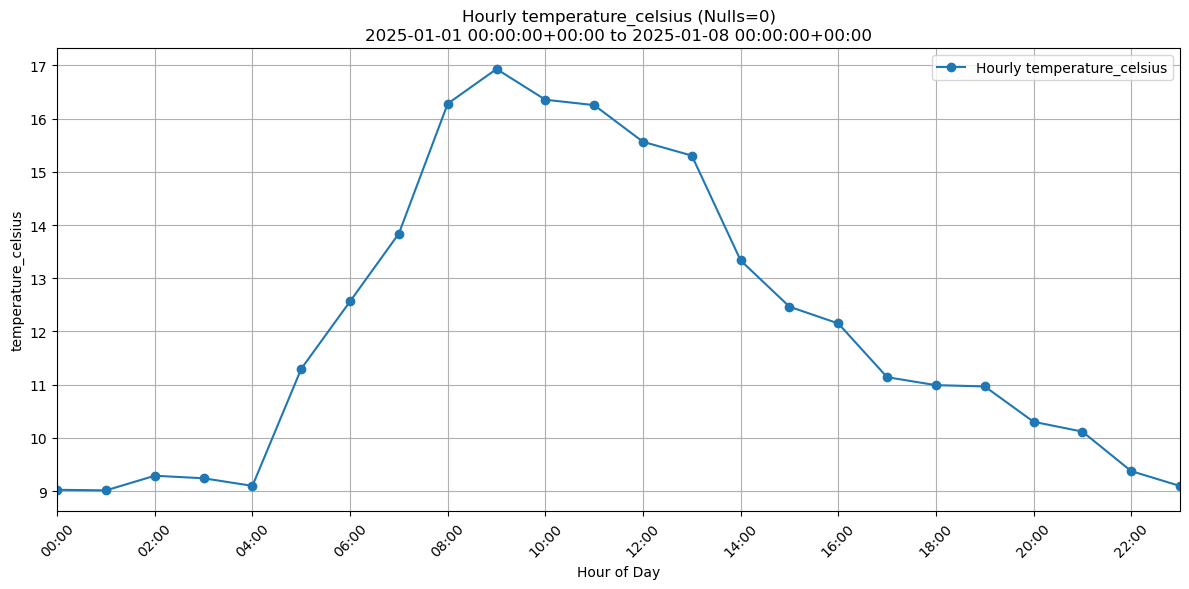

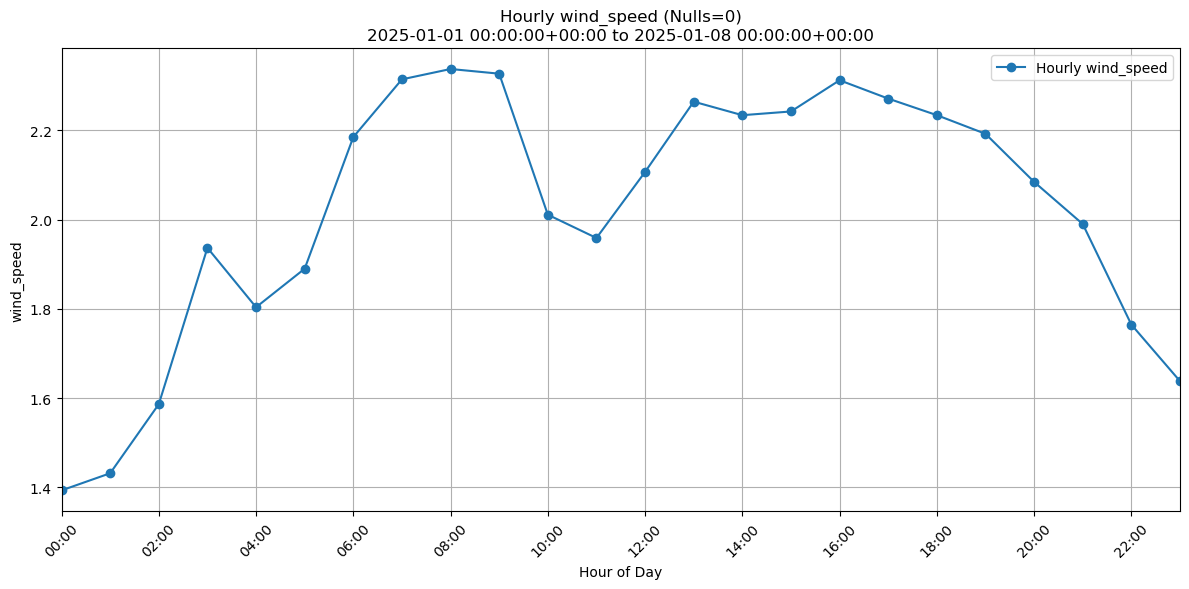

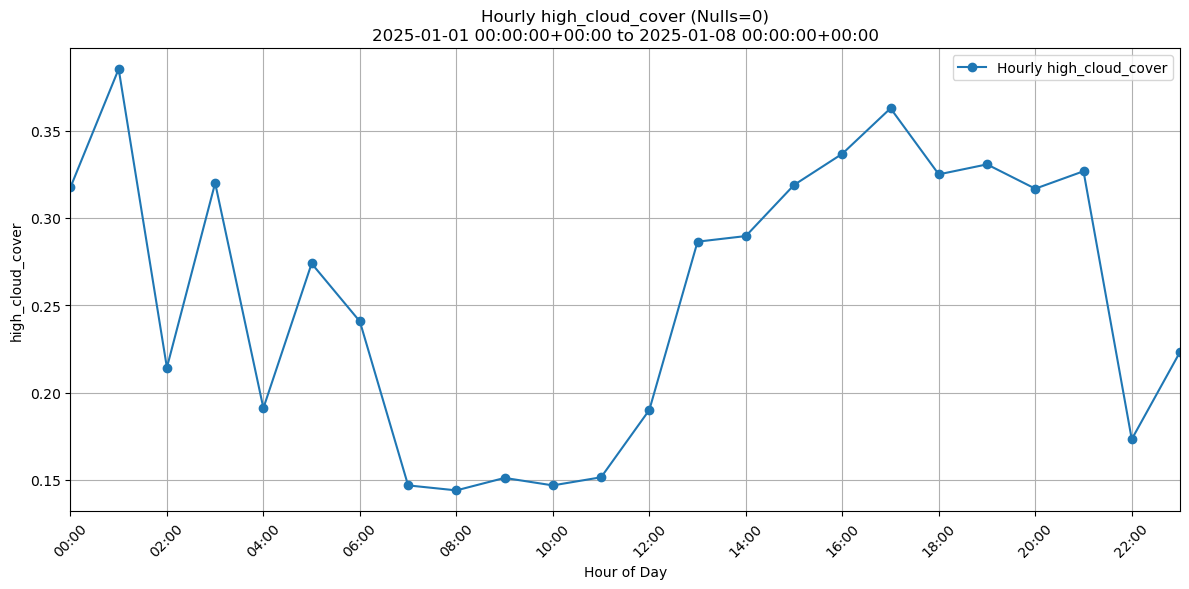

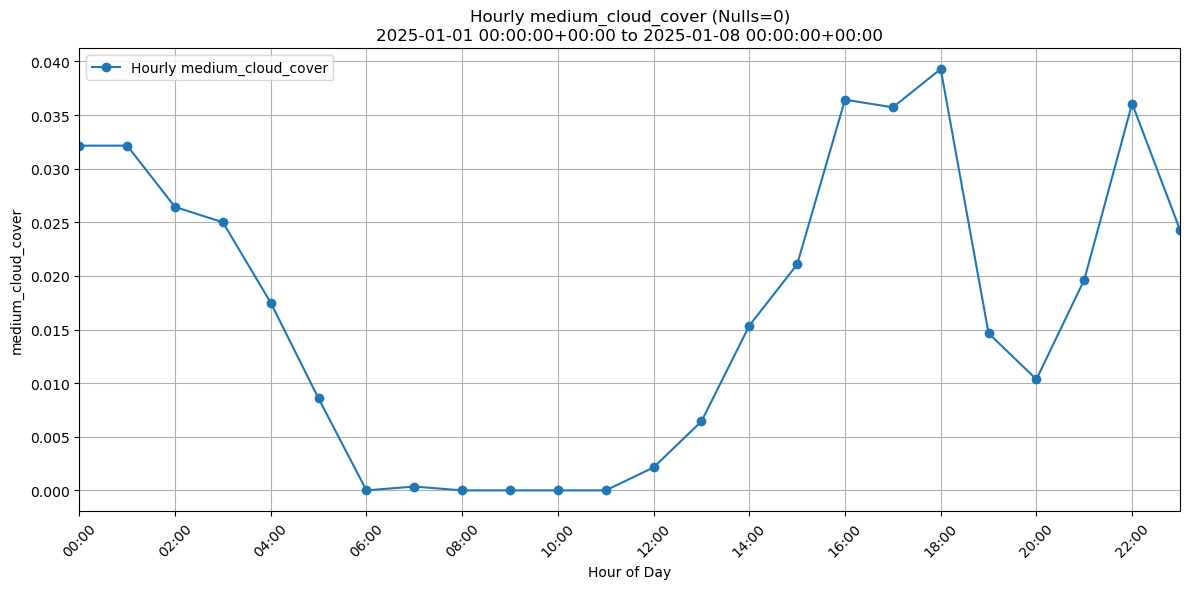

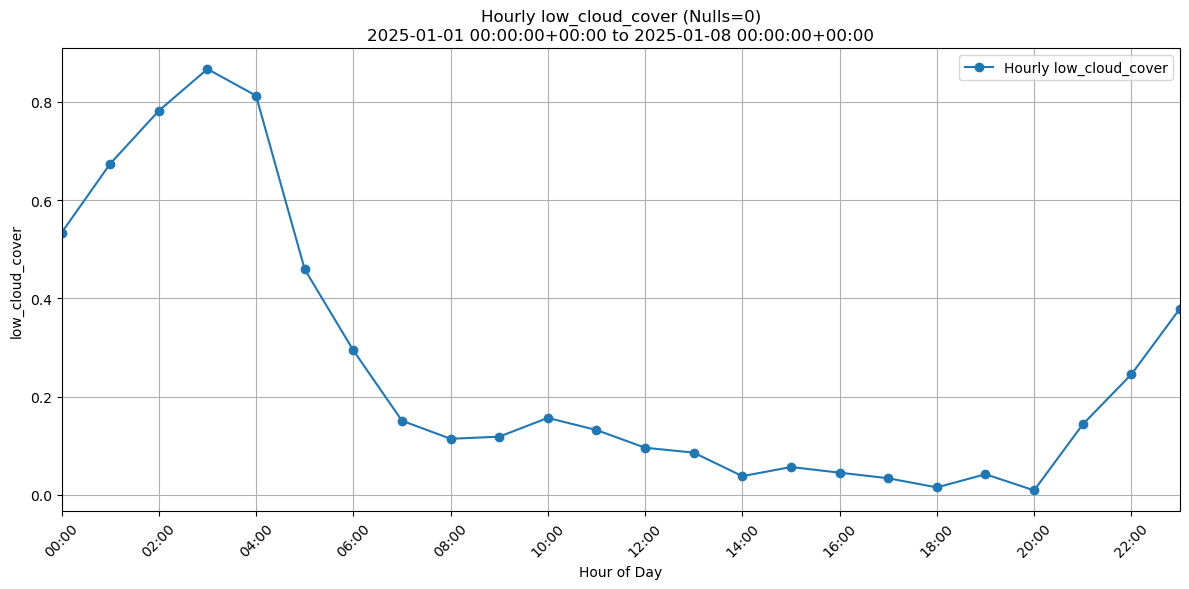

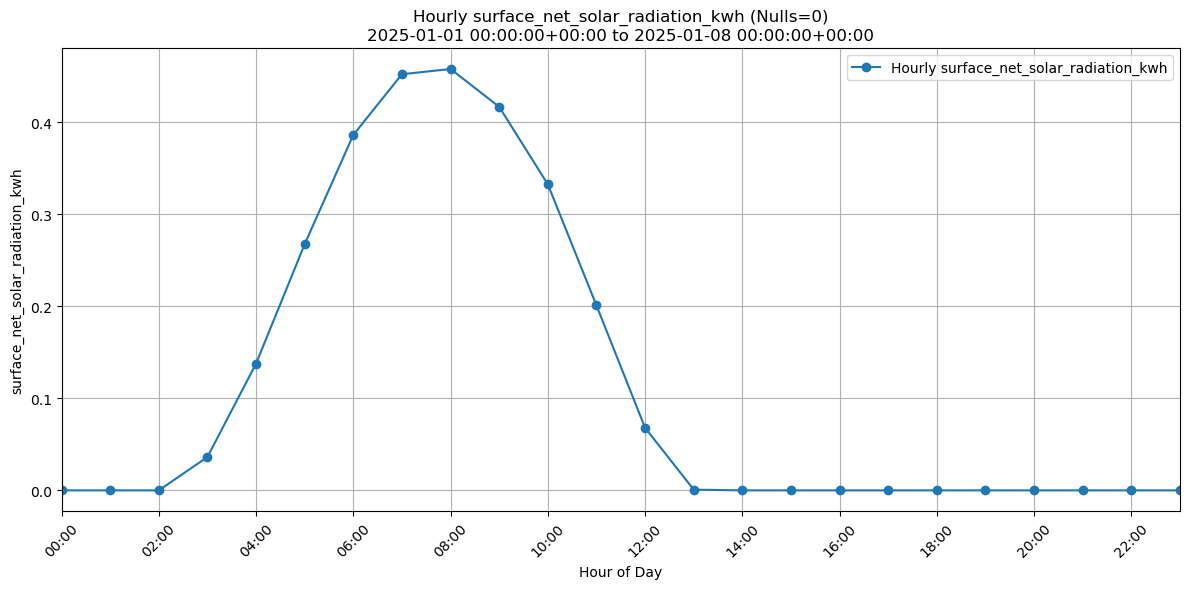

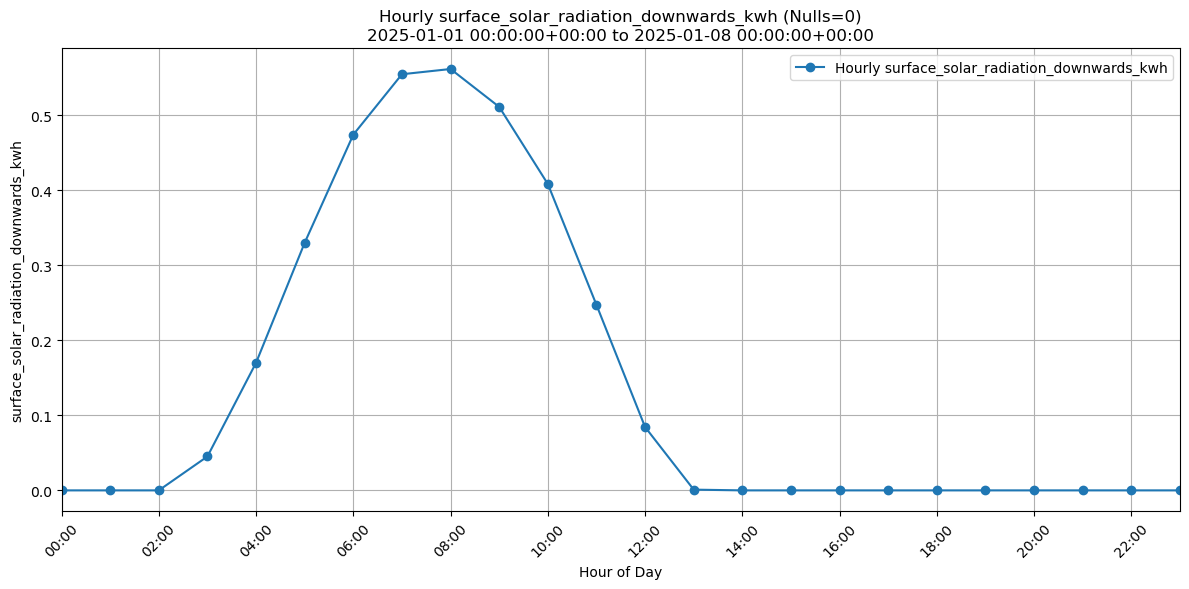

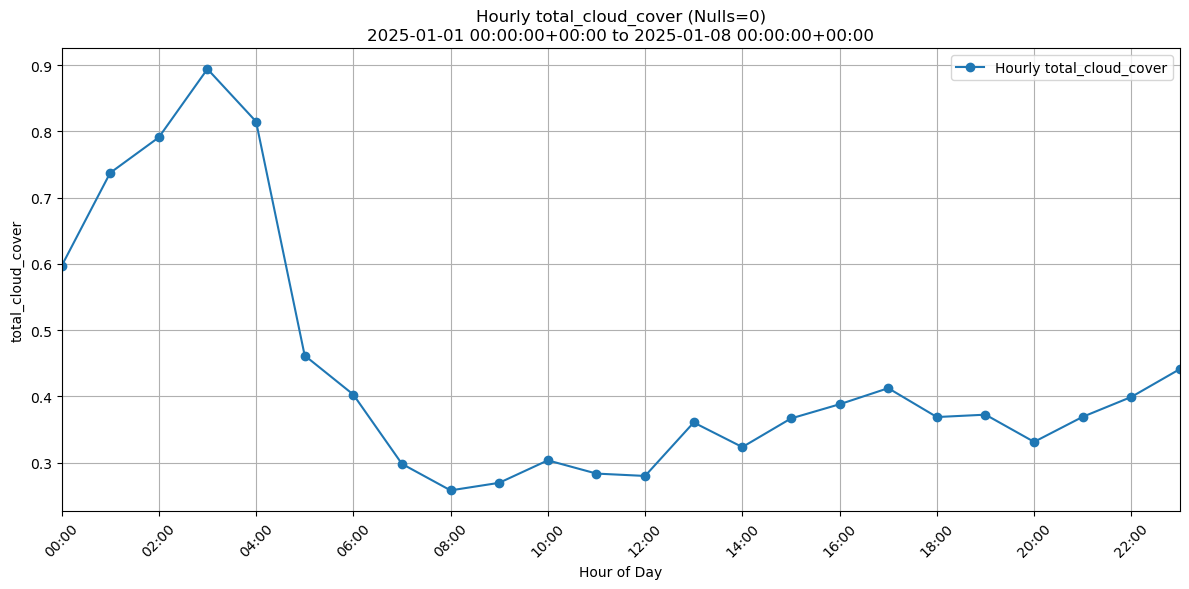

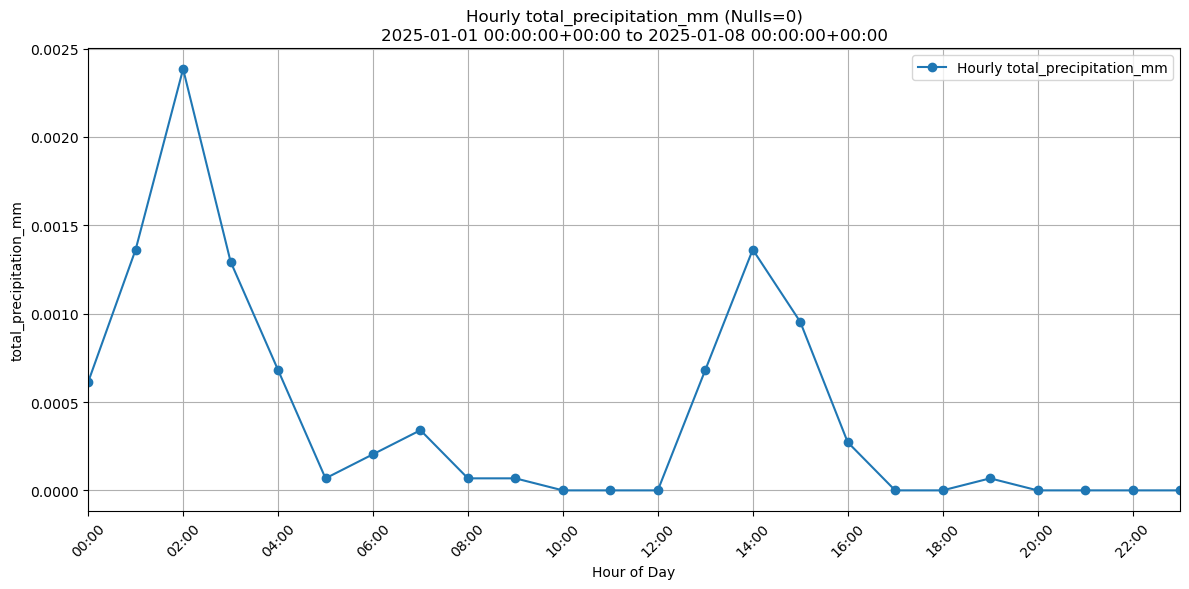

In [ ]:
plot_hourly_averages(
    df=delhi_2025_transformed_pldf,
    start_date="2025-01-01",
    end_date="2025-01-07",
    latitude_col="world_latitude",
    longitude_col="world_longitude",
    latitude_val=30.0,
    longitude_val=75.0,
    variables=["temperature_celsius", "wind_speed", "high_cloud_cover", "medium_cloud_cover", "low_cloud_cover",
               "surface_net_solar_radiation_kwh", "surface_solar_radiation_downwards_kwh", "total_cloud_cover", "total_precipitation_mm"],

)

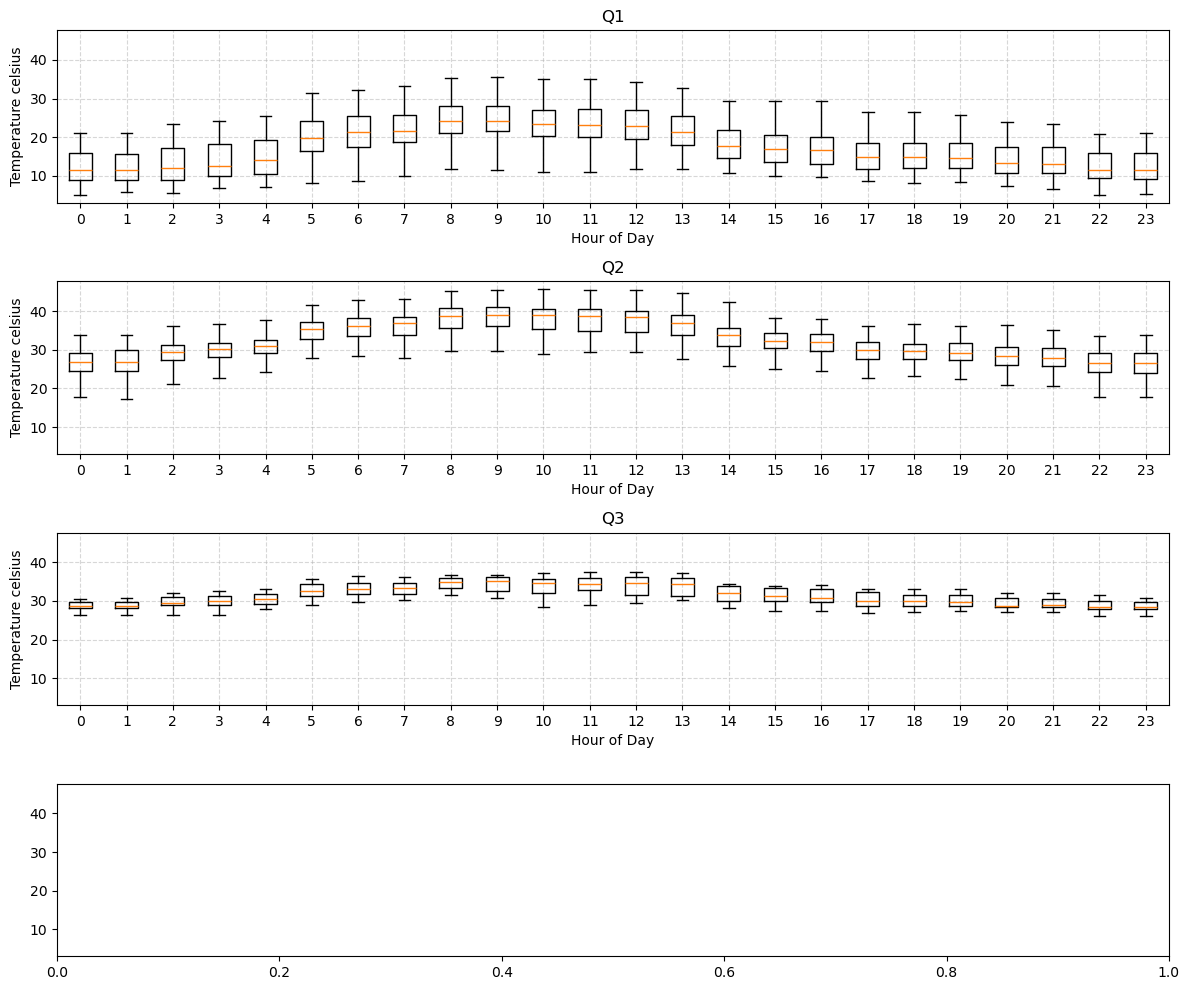

In [ ]:
plot_hourly_boxplots_by_month_or_quarter(
    df=delhi_2025_transformed_pldf,
    variable="temperature_celsius",
    latitude_col="world_latitude",
    longitude_col="world_longitude",
    latitude_val=30.0,
    longitude_val=75.0,
    use_quarters=True
)

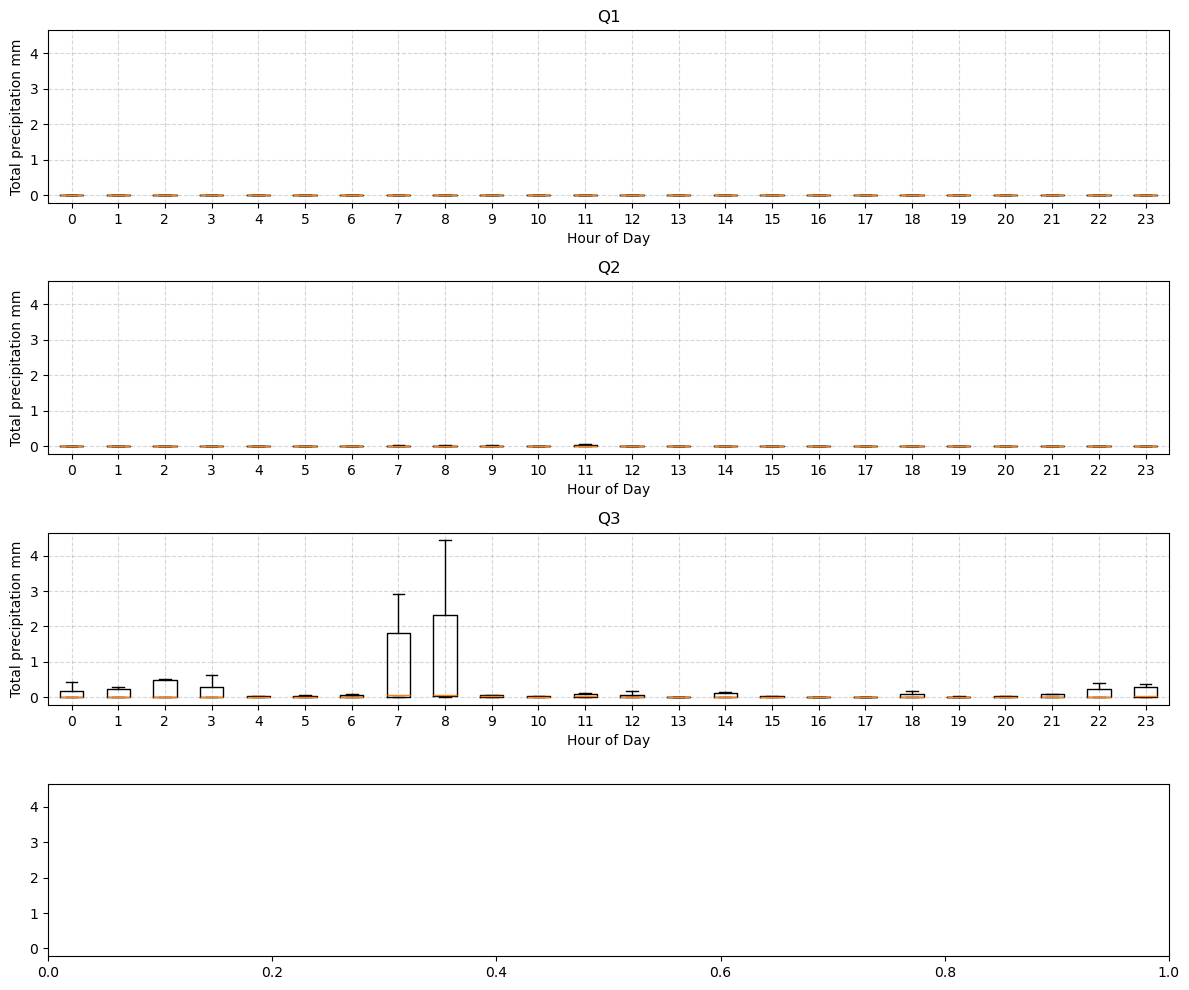

In [ ]:
plot_hourly_boxplots_by_month_or_quarter(
    df=delhi_2025_transformed_pldf,
    variable="total_precipitation_mm",
    latitude_col="world_latitude",
    longitude_col="world_longitude",
    latitude_val=30.0,
    longitude_val=75.0,
    use_quarters=True
)

In [ ]:
unique_locations_only = era5_all_years_pldf.select(
    pl.col("world_latitude"),
    pl.col("world_longitude"),
).unique(maintain_order=True)

print(f"Total unique locations in the dataset: {unique_locations_only.height}")

Total unique locations in the dataset: 3362


In [ ]:
unique_locations_only = unique_locations_only.with_columns(
    pl.col("world_latitude").round(3),
    pl.col("world_longitude").round(3),
).unique(maintain_order=True)
print(f"Total unique locations after rounding: {unique_locations_only.height}")

Total unique locations after rounding: 3362


In [ ]:
dedup_rows = unique_locations_only.unique(
    subset=["world_latitude", "world_longitude"],
    keep="first",
    maintain_order=True
)
print(f"Total unique locations after deduplication: {dedup_rows.height}")

Total unique locations after deduplication: 3362


In [ ]:
dedup_rows.schema

Schema([('world_latitude', Float32), ('world_longitude', Float32)])

In [ ]:
# centers & radius (km)
mumbai_center = (19.10, 72.85)
delhi_center  = (28.61, 77.21)
radius = 60
point_radii = 20
point_color_data = "green"
fill_opacity =0.50
marker_shapes = "square"
km_size = 5

# with_mum = filter_by_radius(with_df, *mumbai_center, radius)
# zero_mum = filter_by_radius(zero_df, *mumbai_center, radius)
# with_del = filter_by_radius(with_df, *delhi_center,  radius)
# zero_del = filter_by_radius(zero_df, *delhi_center,  radius)

In [ ]:
# All locations, both variants (bigger red for missing to make them pop)
make_map(
    unique_locations_only,             # with_df
    None,                              # zero_df → single layer
    title="ERA5 World Data Locations",
    html_basename="era5_world_data_locations",
    output_dir=outputs_images_directory,
    lat_col="world_latitude",
    lon_col="world_longitude",
    variant="withdata",
    marker_shape_with="square",
    square_side_km_with=9,             # fixed-geo 9 km squares (optional)
    color_withdata_only="green",
    point_radius_with=20,              # used if you switch to pixel markers
    fill_opacity=0.5,
    use_cluster=False,                 # geo-sized shapes bypass clustering anyway
)

[ok] wrote ./outputs/images/era5_world_data_locations.html


'./outputs/images/era5_world_data_locations.html'

### Summary

**Overview**
This notebook processes ERA5 world reanalysis data from raw GRIB files into analysis-ready parquet format. The data covers Delhi and Mumbai regions from 2020-2025 and provides high-resolution (0.1°) gridded weather variables for climate and energy modeling.


**Data Structure**
- **Spatial Coverage**: Two distinct geographic regions:
  - Delhi: 26°N-30°N, 75°E-79°E 
  - Mumbai: 17°N-21°N, 70°E-74°E
- **Temporal Range**: Hourly data from 2020-2025
- **Variables**: 10 core meteorological parameters including temperature, wind components, cloud cover, and precipitation
- **Resolution**: Original ERA5 data regridded from 0.25° x 0.25° to 0.1° × 0.1° (approximately 11km)

**Processing Pipeline**
1. **Time Coordinate Unification**:
   - Harmonized inconsistent time representations across variables
   - Created unified time axis for consistent temporal sampling
   
2. **Spatial Regridding**:
   - Applied variable-specific interpolation methods:
     - Conservative methods for precipitation and radiation
     - Bilinear interpolation for temperature and wind components
     - Nearest-neighbor for cloud cover variables
   - Generated and cached regridding weights for computational efficiency

3. **Unit Conversion and Derivation**:
   - Temperature: Kelvin to Celsius
   - Solar radiation: Joules/m² to kWh/m²
   - Precipitation: Meters to millimeters
   - Wind: U/V components to speed and meteorological direction

4. **Data Quality Assessment**:
   - Identified and analyzed null patterns across all variables
   - No significant data gaps found in the processed ERA5 world datasets
   - Performed temporal consistency checks across years

**Technical Implementation**
- **Parallelization**: Used ThreadPoolExecutor for concurrent processing of variables
- **Streaming**: Implemented efficient streaming processing for large datasets
- **Caching**: Created weight files to speed up repeated regridding operations
- **Format Conversion**: Transformed from GRIB scientific format to analysis-friendly parquet

**Technical Notes**
- Storage efficiency improved by:
  - Dropping redundant columns (time/valid_time, step, number, surface)
  - Optimizing data types (32-bit floats for most variables)
  - Using Snappy compression for parquet files
- Final dataset size: ~1.4GB covering 5.5 years of hourly data

**Visualization Insights**
- **Diurnal Patterns**: Clear daily cycles observed in temperature, solar radiation, and wind
- **Seasonal Variation**: Quarterly boxplots reveal:
  - Q2 (Apr-Jun) has highest temperatures with large diurnal range
  - Q3 (Jul-Sep) shows highest precipitation, especially during afternoon hours
  - Wind speeds generally peak in afternoons but show less seasonal variation


**Next Steps**
1. **Time Zone Handling**: Current timestamps are in UTC; convert to local time (IST) during analysis

